In [ ]:
#install tensorflow federated
!pip install -U flwr["simulation"] tensorflow_privacy tensorflow_federated

In [ ]:
#imports and load data from sql server
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow_federated as tff
import tensorflow_privacy
from datetime import datetime
from time import time
import collections
import tensorflow as tf
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import VectorizedDPKerasSGDOptimizer
import numpy as np
from typing import Any, Callable, Dict, List, Optional, Tuple
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


import flwr as fl
from flwr.common import EvaluateIns, NDArrays, Parameters, Scalar, Metrics
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

# Enable GPU growth
enable_tf_gpu_growth()
tff.simulation.datasets.emnist.load_data(only_digits=True)

(<tensorflow_federated.python.simulation.datasets.client_data.PreprocessClientData at 0x7f4098328250>,
 <tensorflow_federated.python.simulation.datasets.client_data.PreprocessClientData at 0x7f40581c8460>)

In [ ]:
#HyperParameters

NUM_CLIENTS = 100
BATCH_SIZE = 8
MICROBATCH_NUM = 4
EPOCHS = 5
ROUNDS = 50

SGD_LEARNING_RATE = .1
SGD_NOISE = .2
L2_NORM_CLIP = 1

In [ ]:
#class defining individual flower client
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train, x_val, y_val, cid) -> None:

        optimizer =  VectorizedDPKerasSGDOptimizer(
                              l2_norm_clip=L2_NORM_CLIP,
                              noise_multiplier=SGD_NOISE,
                              num_microbatches=MICROBATCH_NUM,
                              learning_rate=SGD_LEARNING_RATE)

        loss = tf.keras.losses.CategoricalCrossentropy(
                              from_logits=True,
                              reduction=tf.losses.Reduction.NONE)

        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

        x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

        self.model = model
        self.x_train, self.y_train, self.x_val, self.y_val = x_train, y_train, x_val, y_val
        self.x_test, self.y_test = x_test, y_test
        self.cid = cid

    def get_parameters(self,config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        previous_loss, _ = self.model.evaluate(self.x_test, self.y_test, verbose=2)
        hist = self.model.fit(self.x_train, self.y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
        current_loss = hist.history['loss'][0]
        k_param = previous_loss / current_loss

        return self.model.get_weights(), len(self.x_train), {"metrics": k_param}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)

        loss, accuracy = self.model.evaluate(self.x_val, self.y_val, verbose=2)

        f = open("client_logs.txt", "a")
        time = datetime.now().time()
        f.write(str(time) + " " + self.cid + " " + str(len(self.x_train)) + " " + str(loss) + " " + str(accuracy) + "\n")
        f.close()

        return loss, len(self.x_val), {"accuracy": accuracy, "loss": loss}

In [ ]:
#data processing
@tf.autograph.experimental.do_not_convert
def preprocess(dataset, batch_size):

  def batch_format_fn(element):
    # Flatten a batch 'pixels'
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 28,28]),
        y=tf.reshape(element['label'], [-1, 1]))

    # Shuffle data for 100 clients and prefetch 10
  return dataset.shuffle(100, seed=1).batch(
      batch_size).map(batch_format_fn).prefetch(10)

In [ ]:
#load in specific partition of dataset based on client id
def load_partition(idx: int):

    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)
    client_train = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[idx])
    client_test = emnist_test.create_tf_dataset_for_client(emnist_test.client_ids[idx])

    processed_train = preprocess(client_train, len(list(client_train)))
    processed_test = preprocess(client_test, len(list(client_test)))

    sample_train = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(processed_train)))

    sample_test = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(processed_test)))

    x_train = sample_train['x']
    y_train = sample_train['y']

    x_test = sample_test['x']
    y_test = sample_test['y']

    #Reshape to proper dimensions
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

    # If number of overall training samples not evenly divided by batch size.
    # Because every batch needs to be evenly divided by Microbatch_Num
    if x_train.shape[0] % BATCH_SIZE != 0:
      drop_num = x_train.shape[0] % BATCH_SIZE
      x_train = x_train[:-drop_num]
      y_train = y_train[:-drop_num]

    if x_train.shape[0] % BATCH_SIZE != 0:
        raise ValueError("Batch Size should divide total train samples")

    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


    y_train = np.array(y_train, dtype=np.int32)
    y_test = np.array(y_test, dtype=np.int32)

    # Hot Encoding of data
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

    return (x_train,y_train),(x_test,y_test)

In [ ]:
#CNN Model for Client and Server

def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# Get FlowerClient Model and Batched Data
def client_fn(cid: str) -> fl.client.Client:
    model = create_cnn_model()
    (x_train, y_train), (x_val, y_val) = load_partition(int(cid))
    return FlowerClient(model, x_train, y_train, x_val, y_val, cid)

In [ ]:
#server-side evaluation
def get_eval_fn(model):

    x_vals = np.empty((0,28,28,1))
    y_vals = np.empty((0,10))

    for i in range(NUM_CLIENTS):
        emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)
        client_test = emnist_test.create_tf_dataset_for_client(emnist_train.client_ids[i])

        processed_client_test = preprocess(client_test, len(list(client_test)))
        sample_test = tf.nest.map_structure(lambda x: x.numpy(),
                                         next(iter(processed_client_test)))
        x = sample_test['x']
        x = x.reshape(x.shape[0], 28, 28, 1)

        y = np.array(sample_test['y'], dtype=np.int32)
        y = tf.keras.utils.to_categorical(y, num_classes=10)

        _ , x_test, _, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

        x_vals = np.append(x_vals, x_test, axis=0)
        y_vals = np.append(y_vals, y_test, axis=0)

    def evaluate(server_round: int, parameters: NDArrays, config: Dict[str, fl.common.Scalar]):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(x_vals, y_vals)
        num_examples = len(x_vals)

        print('\nserver accuracy ' + str(accuracy))
        print('server loss ' + str(loss) + "\n")

        f = open("server_logs.txt", "a")
        time = datetime.now().time()
        f.write(str(time) + " " + str(num_examples) + " " + str(loss) + " " + str(accuracy)+ "\n")
        f.close()

        return loss, {"accuracy": accuracy, "loss": loss}

    return evaluate

In [ ]:
class custom_FedAvg(fl.server.strategy.FedAvg):
  def configure_evaluate(self,
                         server_round: int,
                         parameters: Parameters,
                         client_manager: ClientManager) -> List[Tuple[ClientProxy, EvaluateIns]]:
    """Configure the next round of evaluation."""
    # Parameters and config
    config = {}
    if self.on_evaluate_config_fn is not None:
        config = self.on_evaluate_config_fn(server_round)
    evaluate_ins = EvaluateIns(parameters, config)

    # Sample clients
    if server_round >= 0:
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
    else:
        clients = list(client_manager.all().values())

    # Return client/config pairs
    return [(client, evaluate_ins) for client in clients]

In [ ]:
accuray_var_list = []
loss_var_list = []

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m["loss"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy_variance = np.var(np.array([m["accuracy"] for _, m in metrics]))
    # Calculate variance for losses
    loss_variance = np.var(np.array([m["loss"] for _, m in metrics]))

    accuray_var_list.append(accuracy_variance)
    loss_var_list.append(loss_variance)

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples), "loss": sum(losses) / sum(examples)}

In [ ]:

model = create_cnn_model()
model.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Create FedAvg strategy
strategy=custom_FedAvg(
        fraction_fit=0.1,                               # Sample 10% Clients for training
        fraction_evaluate=0.1,                          # Sample 10% Clients for Validation
        min_fit_clients=10,                             # Makesure atleast 10 clients available for training
        min_evaluate_clients=10,                        # Makesure atleast 10 clients available for training
        min_available_clients=int(NUM_CLIENTS * 0.75),  # Wait until 75 clients are free
        evaluate_metrics_aggregation_fn=weighted_average,
        evaluate_fn=get_eval_fn(model))

# Start simulation
start_time = time()
client_resources = {"num_cpus": 1, "num_gpus": 1.0}

history =fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },)

end_time = time()

print("WallClock Time: " + str(end_time-start_time))

INFO flwr 2023-11-29 05:00:25,293 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
2023-11-29 05:00:27,498	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-11-29 05:00:28,833 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 32521413428.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 16260706713.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 32521413428.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 16260706713.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
INFO flwr 2023-11-29 05:00:28,835 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations

19/19 [==============================] - 8s 5ms/step - loss: 2.3087 - accuracy: 0.1302


INFO flwr 2023-11-29 05:00:43,227 | server.py:94 | initial parameters (loss, other metrics): 2.3086705207824707, {'accuracy': 0.1302170306444168, 'loss': 2.3086705207824707}
INFO:flwr:initial parameters (loss, other metrics): 2.3086705207824707, {'accuracy': 0.1302170306444168, 'loss': 2.3086705207824707}
INFO flwr 2023-11-29 05:00:43,229 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-11-29 05:00:43,231 | server.py:222 | fit_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 1: strategy sampled 10 clients (out of 100)



server accuracy 0.1302170306444168
server loss 2.3086705207824707



(DefaultActor pid=5560) /usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
(DefaultActor pid=5560)   output, from_logits = _get_logits(


(DefaultActor pid=5560) 1/1 - 2s - loss: 2.2770 - accuracy: 0.1429 - 2s/epoch - 2s/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 4s - loss: 2.3345 - accuracy: 0.0577 - 4s/epoch - 292ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.3046 - accuracy: 0.1058 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.3066 - accuracy: 0.0962 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.3163 - accuracy: 0.1346 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.3164 - accuracy: 0.0865 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3532 - accuracy: 0.0000e+00 - 244ms/epoch - 244ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 2.3227 - accuracy: 0.1250 - 2s/epoch - 178ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=

(DefaultActor pid=5560) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x7adf335e29e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(DefaultActor pid=5560) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x7adf335e29e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function re

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2786 - accuracy: 0.3333 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 2.3307 - accuracy: 0.0909 - 2s/epoch - 158ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.3031 - accuracy: 0.0909 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.3033 - accuracy: 0.1364 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.3042 - accuracy: 0.1136 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.3044 - accuracy: 0.1023 - 36ms/epoch - 3ms/step


(DefaultActor pid=5560) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x7adf33403c70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
(DefaultActor pid=5560) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x7adf33403c70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function re

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2967 - accuracy: 0.0000e+00 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 2.3368 - accuracy: 0.0729 - 2s/epoch - 147ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 2.3276 - accuracy: 0.0833 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 2.3275 - accuracy: 0.1250 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 2.3012 - accuracy: 0.1458 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 2.3027 - accuracy: 0.1875 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2872 - accuracy: 0.2857 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 14/14 - 2s - loss: 2.3433 - accuracy: 0.0625 - 2s/epoch - 126ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActo

DEBUG flwr 2023-11-29 05:01:11,840 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-11-29 05:01:11,856 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


(DefaultActor pid=5560) 10/10 - 2s - loss: 2.3253 - accuracy: 0.1375 - 2s/epoch - 175ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.3270 - accuracy: 0.1500 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.3057 - accuracy: 0.1375 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.2896 - accuracy: 0.1375 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.2934 - accuracy: 0.1500 - 32ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 2.2927 - accuracy: 0.1436


INFO flwr 2023-11-29 05:01:11,972 | server.py:125 | fit progress: (1, 2.2926549911499023, {'accuracy': 0.1435726135969162, 'loss': 2.2926549911499023}, 28.741617920999943)
INFO:flwr:fit progress: (1, 2.2926549911499023, {'accuracy': 0.1435726135969162, 'loss': 2.2926549911499023}, 28.741617920999943)
DEBUG flwr 2023-11-29 05:01:11,974 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 100)



server accuracy 0.1435726135969162
server loss 2.2926549911499023

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2923 - accuracy: 0.1667 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3121 - accuracy: 0.0000e+00 - 242ms/epoch - 242ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2750 - accuracy: 0.1667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2878 - accuracy: 0.1667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2950 - accuracy: 0.0000e+00 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3082 - accuracy: 0.0000e+00 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3251 - accuracy: 0.3333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 1s - loss: 2.3042 - accuracy: 0.0000e+00 - 644ms/epoch - 644ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2937 - accuracy: 0.2500 - 210ms/epoch - 210ms/step


DEBUG flwr 2023-11-29 05:01:17,246 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:01:17,249 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2783 - accuracy: 0.2000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2981 - accuracy: 0.0000e+00 - 215ms/epoch - 215ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 2.2991 - accuracy: 0.1146 - 2s/epoch - 156ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 2.2911 - accuracy: 0.1458 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 2.2842 - accuracy: 0.1458 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 2.2723 - accuracy: 0.1562 - 40ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 2.2681 - accuracy: 0.1458 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2672 - accuracy: 0.0000e+00 - 211ms/epoch - 211ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss

DEBUG flwr 2023-11-29 05:01:42,399 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


(DefaultActor pid=5560) 7/7 - 2s - loss: 2.2777 - accuracy: 0.0714 - 2s/epoch - 245ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 7/7 - 0s - loss: 2.2152 - accuracy: 0.0893 - 23ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 7/7 - 0s - loss: 2.1718 - accuracy: 0.2500 - 23ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 7/7 - 0s - loss: 2.1494 - accuracy: 0.2143 - 23ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 7/7 - 0s - loss: 2.1399 - accuracy: 0.2143 - 22ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.2867 - accuracy: 0.1753


INFO flwr 2023-11-29 05:01:42,523 | server.py:125 | fit progress: (2, 2.2867157459259033, {'accuracy': 0.17529214918613434, 'loss': 2.2867157459259033}, 59.29238067999995)
INFO:flwr:fit progress: (2, 2.2867157459259033, {'accuracy': 0.17529214918613434, 'loss': 2.2867157459259033}, 59.29238067999995)
DEBUG flwr 2023-11-29 05:01:42,525 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 100)



server accuracy 0.17529214918613434
server loss 2.2867157459259033

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2852 - accuracy: 0.2000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2802 - accuracy: 0.1667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2904 - accuracy: 0.0000e+00 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2982 - accuracy: 0.2857 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3074 - accuracy: 0.0000e+00 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2938 - accuracy: 0.2000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3399 - accuracy: 0.0000e+00 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3278 - accuracy: 0.0000e+00 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3044 - accuracy: 0.0000e+00 - 201ms/epoch - 201ms/step


DEBUG flwr 2023-11-29 05:01:47,332 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:01:47,336 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2903 - accuracy: 0.0000e+00 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2984 - accuracy: 0.2000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 2.2988 - accuracy: 0.1500 - 2s/epoch - 175ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.2924 - accuracy: 0.1375 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.2791 - accuracy: 0.1125 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.2814 - accuracy: 0.2125 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.2713 - accuracy: 0.1875 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3673 - accuracy: 0.0000e+00 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss

DEBUG flwr 2023-11-29 05:02:12,924 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


(DefaultActor pid=5560) 11/11 - 2s - loss: 2.3000 - accuracy: 0.1250 - 2s/epoch - 164ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.2857 - accuracy: 0.1136 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.2645 - accuracy: 0.1818 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.2632 - accuracy: 0.1136 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.2398 - accuracy: 0.2500 - 35ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 2.2571 - accuracy: 0.1803


INFO flwr 2023-11-29 05:02:13,055 | server.py:125 | fit progress: (3, 2.2571136951446533, {'accuracy': 0.1803005039691925, 'loss': 2.2571136951446533}, 89.82415831699996)
INFO:flwr:fit progress: (3, 2.2571136951446533, {'accuracy': 0.1803005039691925, 'loss': 2.2571136951446533}, 89.82415831699996)
DEBUG flwr 2023-11-29 05:02:13,057 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 100)



server accuracy 0.1803005039691925
server loss 2.2571136951446533

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2534 - accuracy: 0.0000e+00 - 237ms/epoch - 237ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2510 - accuracy: 0.1667 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2145 - accuracy: 0.3333 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2623 - accuracy: 0.5000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2704 - accuracy: 0.1667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2868 - accuracy: 0.0000e+00 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2372 - accuracy: 0.2500 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3000 - accuracy: 0.1667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2971 - accuracy: 0.0000e+00 - 195ms/epoch - 195ms/step


DEBUG flwr 2023-11-29 05:02:17,800 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:02:17,803 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1554 - accuracy: 0.5000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2551 - accuracy: 0.1667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 2.2832 - accuracy: 0.1136 - 2s/epoch - 160ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.2703 - accuracy: 0.1705 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.2646 - accuracy: 0.2500 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.2553 - accuracy: 0.1136 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.2480 - accuracy: 0.1250 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1866 - accuracy: 0.4000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 9/9 - 2s - loss: 2.2616 -

DEBUG flwr 2023-11-29 05:02:43,151 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 2.2565 - accuracy: 0.2308 - 2s/epoch - 133ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.2042 - accuracy: 0.2692 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.1521 - accuracy: 0.2596 - 40ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.1156 - accuracy: 0.3269 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.0619 - accuracy: 0.3269 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.2129 - accuracy: 0.3539


INFO flwr 2023-11-29 05:02:43,276 | server.py:125 | fit progress: (4, 2.2128660678863525, {'accuracy': 0.3539232015609741, 'loss': 2.2128660678863525}, 120.04493583399994)
INFO:flwr:fit progress: (4, 2.2128660678863525, {'accuracy': 0.3539232015609741, 'loss': 2.2128660678863525}, 120.04493583399994)
DEBUG flwr 2023-11-29 05:02:43,277 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 100)



server accuracy 0.3539232015609741
server loss 2.2128660678863525

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1650 - accuracy: 0.5000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2308 - accuracy: 0.1667 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1793 - accuracy: 0.4000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1661 - accuracy: 0.6667 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2238 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2900 - accuracy: 0.3333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2992 - accuracy: 0.0000e+00 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1020 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2723 - accuracy: 0.0000e+00 - 205ms/epoch - 205ms/step


DEBUG flwr 2023-11-29 05:02:47,985 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:02:47,987 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2726 - accuracy: 0.1667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2058 - accuracy: 0.3333 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 2.2205 - accuracy: 0.1932 - 2s/epoch - 160ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.2104 - accuracy: 0.1932 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.1674 - accuracy: 0.2500 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.0869 - accuracy: 0.3636 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 2.0805 - accuracy: 0.3636 - 34ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2220 - accuracy: 0.2857 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 2.2438

DEBUG flwr 2023-11-29 05:03:13,464 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


(DefaultActor pid=5560) 10/10 - 2s - loss: 2.2486 - accuracy: 0.1750 - 2s/epoch - 176ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.2315 - accuracy: 0.2750 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.1997 - accuracy: 0.2125 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.2119 - accuracy: 0.2500 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 2.2252 - accuracy: 0.2250 - 32ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 2.1260 - accuracy: 0.3573


INFO flwr 2023-11-29 05:03:13,587 | server.py:125 | fit progress: (5, 2.1260292530059814, {'accuracy': 0.35726210474967957, 'loss': 2.1260292530059814}, 150.35624819399993)
INFO:flwr:fit progress: (5, 2.1260292530059814, {'accuracy': 0.35726210474967957, 'loss': 2.1260292530059814}, 150.35624819399993)
DEBUG flwr 2023-11-29 05:03:13,590 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 100)



server accuracy 0.35726210474967957
server loss 2.1260292530059814

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0844 - accuracy: 0.4000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1683 - accuracy: 0.1667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1869 - accuracy: 0.3333 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2407 - accuracy: 0.1667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1038 - accuracy: 0.3333 - 246ms/epoch - 246ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1341 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1082 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2280 - accuracy: 0.1667 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0932 - accuracy: 0.6667 - 206ms/epoch - 206ms/step


DEBUG flwr 2023-11-29 05:03:18,406 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:03:18,409 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2005 - accuracy: 0.2000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1040 - accuracy: 0.1429 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 2.1222 - accuracy: 0.3173 - 2s/epoch - 136ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.0712 - accuracy: 0.4423 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.0214 - accuracy: 0.3654 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 1.9608 - accuracy: 0.4519 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 1.8643 - accuracy: 0.5385 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1631 - accuracy: 0.3333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 2.1770

DEBUG flwr 2023-11-29 05:03:42,919 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 2.1536 - accuracy: 0.3365 - 2s/epoch - 140ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.1081 - accuracy: 0.3846 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.0484 - accuracy: 0.5000 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 2.0099 - accuracy: 0.4135 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 1.9055 - accuracy: 0.5288 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 1.9600 - accuracy: 0.5075


INFO flwr 2023-11-29 05:03:43,045 | server.py:125 | fit progress: (6, 1.959965467453003, {'accuracy': 0.5075125098228455, 'loss': 1.959965467453003}, 179.814068723)
INFO:flwr:fit progress: (6, 1.959965467453003, {'accuracy': 0.5075125098228455, 'loss': 1.959965467453003}, 179.814068723)
DEBUG flwr 2023-11-29 05:03:43,046 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 6: strategy sampled 10 clients (out of 100)



server accuracy 0.5075125098228455
server loss 1.959965467453003

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0612 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0606 - accuracy: 0.5000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8748 - accuracy: 0.2000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6936 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8123 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8499 - accuracy: 0.6000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8562 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1231 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0967 - accuracy: 0.3333 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-11-29 05:03:47,833 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:03:47,836 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9202 - accuracy: 0.4286 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7320 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 3s - loss: 2.0441 - accuracy: 0.3068 - 3s/epoch - 275ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 1.9696 - accuracy: 0.4091 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 1.9216 - accuracy: 0.3409 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 1.8627 - accuracy: 0.5227 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 1.7827 - accuracy: 0.6023 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7804 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 9/9 - 2s - loss: 1.9375 -

DEBUG flwr 2023-11-29 05:04:13,565 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 2s - loss: 1.9397 - accuracy: 0.5625 - 2s/epoch - 149ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 1.8265 - accuracy: 0.5417 - 37ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 1.7424 - accuracy: 0.5417 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 1.6964 - accuracy: 0.5208 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 1.5479 - accuracy: 0.5833 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.7070 - accuracy: 0.5943


INFO flwr 2023-11-29 05:04:13,697 | server.py:125 | fit progress: (7, 1.7069637775421143, {'accuracy': 0.5943238735198975, 'loss': 1.7069637775421143}, 210.46646751499998)



server accuracy 0.5943238735198975
server loss 1.7069637775421143



INFO:flwr:fit progress: (7, 1.7069637775421143, {'accuracy': 0.5943238735198975, 'loss': 1.7069637775421143}, 210.46646751499998)
DEBUG flwr 2023-11-29 05:04:13,699 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 7: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5970 - accuracy: 0.8000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8942 - accuracy: 0.3333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7242 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4689 - accuracy: 0.6000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7132 - accuracy: 0.6667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8407 - accuracy: 0.3333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7771 - accuracy: 0.1667 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6197 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7868 - accuracy: 0.2000 - 191ms/epoch - 191ms/step


DEBUG flwr 2023-11-29 05:04:18,449 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:04:18,451 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7450 - accuracy: 0.5000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9648 - accuracy: 0.3333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 1.8277 - accuracy: 0.4167 - 2s/epoch - 148ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 1.7194 - accuracy: 0.5208 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 1.6832 - accuracy: 0.4583 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 1.5685 - accuracy: 0.6042 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 1.4828 - accuracy: 0.6458 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8270 - accuracy: 0.4286 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 1.7461

DEBUG flwr 2023-11-29 05:04:44,291 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


(DefaultActor pid=5560) 9/9 - 2s - loss: 1.6974 - accuracy: 0.5694 - 2s/epoch - 195ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 1.6169 - accuracy: 0.5278 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 1.5814 - accuracy: 0.5833 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 1.5066 - accuracy: 0.5972 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 1.5126 - accuracy: 0.5139 - 30ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 1.4850 - accuracy: 0.6177


INFO flwr 2023-11-29 05:04:44,419 | server.py:125 | fit progress: (8, 1.485047698020935, {'accuracy': 0.6176961660385132, 'loss': 1.485047698020935}, 241.18812304899996)
INFO:flwr:fit progress: (8, 1.485047698020935, {'accuracy': 0.6176961660385132, 'loss': 1.485047698020935}, 241.18812304899996)
DEBUG flwr 2023-11-29 05:04:44,421 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 8: strategy sampled 10 clients (out of 100)



server accuracy 0.6176961660385132
server loss 1.485047698020935

(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6490 - accuracy: 0.5714 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3432 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9087 - accuracy: 0.0000e+00 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5931 - accuracy: 0.3333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4080 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5480 - accuracy: 0.6667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7200 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7258 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6161 - accuracy: 0.2000 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-11-29 05:04:49,127 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:04:49,129 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1860 - accuracy: 0.8333 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8550 - accuracy: 0.1667 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 1.6498 - accuracy: 0.4545 - 2s/epoch - 159ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 1.4874 - accuracy: 0.5568 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 1.3658 - accuracy: 0.6591 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 1.3061 - accuracy: 0.5909 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 1.1804 - accuracy: 0.6818 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4879 - accuracy: 0.4286 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 1.6824

DEBUG flwr 2023-11-29 05:05:13,656 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 1.6233 - accuracy: 0.5962 - 2s/epoch - 137ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 1.5133 - accuracy: 0.5769 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 1.4470 - accuracy: 0.6154 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 1.3871 - accuracy: 0.6442 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 1.2186 - accuracy: 0.7596 - 48ms/epoch - 4ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.2362 - accuracy: 0.6778


INFO flwr 2023-11-29 05:05:13,777 | server.py:125 | fit progress: (9, 1.2362456321716309, {'accuracy': 0.6777963042259216, 'loss': 1.2362456321716309}, 270.54607315499993)
INFO:flwr:fit progress: (9, 1.2362456321716309, {'accuracy': 0.6777963042259216, 'loss': 1.2362456321716309}, 270.54607315499993)
DEBUG flwr 2023-11-29 05:05:13,779 | server.py:173 | evaluate_round 9: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 9: strategy sampled 10 clients (out of 100)



server accuracy 0.6777963042259216
server loss 1.2362456321716309

(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5853 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4966 - accuracy: 0.5000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4024 - accuracy: 0.5714 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6866 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9467 - accuracy: 0.8000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0488 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.2395 - accuracy: 0.5000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0552 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3801 - accuracy: 0.8333 - 195ms/epoch - 195ms/step


DEBUG flwr 2023-11-29 05:05:18,548 | server.py:187 | evaluate_round 9 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:05:18,550 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0393 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0791 - accuracy: 0.8000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 1.1086 - accuracy: 0.7875 - 2s/epoch - 180ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.9989 - accuracy: 0.8250 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.9759 - accuracy: 0.7625 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.9050 - accuracy: 0.8000 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.8018 - accuracy: 0.8375 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9901 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 1.0287

DEBUG flwr 2023-11-29 05:05:44,806 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


(DefaultActor pid=5560) 11/11 - 2s - loss: 0.9414 - accuracy: 0.7614 - 2s/epoch - 159ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.8449 - accuracy: 0.7955 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.7883 - accuracy: 0.8182 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.6688 - accuracy: 0.8864 - 34ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.6867 - accuracy: 0.8182 - 35ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 1.0461 - accuracy: 0.7145


INFO flwr 2023-11-29 05:05:44,932 | server.py:125 | fit progress: (10, 1.0461409091949463, {'accuracy': 0.7145242094993591, 'loss': 1.0461409091949463}, 301.701030728)
INFO:flwr:fit progress: (10, 1.0461409091949463, {'accuracy': 0.7145242094993591, 'loss': 1.0461409091949463}, 301.701030728)
DEBUG flwr 2023-11-29 05:05:44,934 | server.py:173 | evaluate_round 10: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 10: strategy sampled 10 clients (out of 100)



server accuracy 0.7145242094993591
server loss 1.0461409091949463

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7398 - accuracy: 0.8000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0410 - accuracy: 0.6000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9055 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7504 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4322 - accuracy: 0.4000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5765 - accuracy: 0.1667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8380 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.2240 - accuracy: 0.5000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9565 - accuracy: 0.5714 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-11-29 05:05:49,729 | server.py:187 | evaluate_round 10 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:05:49,731 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6008 - accuracy: 0.8000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3229 - accuracy: 0.5000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 1.1357 - accuracy: 0.6477 - 2s/epoch - 158ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 1.0290 - accuracy: 0.7159 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.9914 - accuracy: 0.6705 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.8970 - accuracy: 0.7841 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.8367 - accuracy: 0.7386 - 34ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4226 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.7720

DEBUG flwr 2023-11-29 05:06:14,076 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures


(DefaultActor pid=5560) 9/9 - 2s - loss: 0.7909 - accuracy: 0.7500 - 2s/epoch - 202ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.7688 - accuracy: 0.7083 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.7289 - accuracy: 0.7222 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.5864 - accuracy: 0.8472 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.9110 - accuracy: 0.7346


INFO flwr 2023-11-29 05:06:14,199 | server.py:125 | fit progress: (11, 0.9109975099563599, {'accuracy': 0.734557569026947, 'loss': 0.9109975099563599}, 330.9688967249999)
INFO:flwr:fit progress: (11, 0.9109975099563599, {'accuracy': 0.734557569026947, 'loss': 0.9109975099563599}, 330.9688967249999)
DEBUG flwr 2023-11-29 05:06:14,203 | server.py:173 | evaluate_round 11: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 11: strategy sampled 10 clients (out of 100)



server accuracy 0.734557569026947
server loss 0.9109975099563599

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5508 - accuracy: 0.6000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3842 - accuracy: 0.5000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8162 - accuracy: 0.6000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9561 - accuracy: 0.1667 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3667 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5644 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4398 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9434 - accuracy: 0.3333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5164 - accuracy: 0.3333 - 197ms/epoch - 197ms/step


DEBUG flwr 2023-11-29 05:06:19,038 | server.py:187 | evaluate_round 11 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:06:19,040 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5409 - accuracy: 0.5000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8796 - accuracy: 0.5714 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.7099 - accuracy: 0.8269 - 2s/epoch - 135ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.6911 - accuracy: 0.7885 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.5718 - accuracy: 0.8942 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.5115 - accuracy: 0.8750 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4818 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7726 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 1.1740

DEBUG flwr 2023-11-29 05:06:45,715 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 2s - loss: 0.7599 - accuracy: 0.7708 - 2s/epoch - 150ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6584 - accuracy: 0.8958 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6702 - accuracy: 0.8229 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6332 - accuracy: 0.7917 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5830 - accuracy: 0.8021 - 36ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.8325 - accuracy: 0.7429


INFO flwr 2023-11-29 05:06:45,839 | server.py:125 | fit progress: (12, 0.8325090408325195, {'accuracy': 0.7429048418998718, 'loss': 0.8325090408325195}, 362.608145528)
INFO:flwr:fit progress: (12, 0.8325090408325195, {'accuracy': 0.7429048418998718, 'loss': 0.8325090408325195}, 362.608145528)
DEBUG flwr 2023-11-29 05:06:45,842 | server.py:173 | evaluate_round 12: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 12: strategy sampled 10 clients (out of 100)



server accuracy 0.7429048418998718
server loss 0.8325090408325195

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4511 - accuracy: 0.8000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2894 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3149 - accuracy: 1.0000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7831 - accuracy: 0.6667 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1649 - accuracy: 0.4000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8025 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0063 - accuracy: 0.4000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9561 - accuracy: 0.2000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5275 - accuracy: 0.8333 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-11-29 05:06:50,678 | server.py:187 | evaluate_round 12 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:06:50,681 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 13: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9255 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6757 - accuracy: 0.6000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 9/9 - 2s - loss: 0.5353 - accuracy: 0.7917 - 2s/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.4317 - accuracy: 0.9306 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.4743 - accuracy: 0.8750 - 28ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.4300 - accuracy: 0.8056 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.3693 - accuracy: 0.9167 - 30ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.2652 - accuracy: 0.7143 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.6727 - accurac

DEBUG flwr 2023-11-29 05:07:15,469 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 2s - loss: 0.6534 - accuracy: 0.7708 - 2s/epoch - 148ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6204 - accuracy: 0.8021 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5832 - accuracy: 0.8229 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5504 - accuracy: 0.8542 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.7796


INFO flwr 2023-11-29 05:07:15,601 | server.py:125 | fit progress: (13, 0.7004098892211914, {'accuracy': 0.7796327471733093, 'loss': 0.7004098892211914}, 392.37028427099995)
INFO:flwr:fit progress: (13, 0.7004098892211914, {'accuracy': 0.7796327471733093, 'loss': 0.7004098892211914}, 392.37028427099995)
DEBUG flwr 2023-11-29 05:07:15,603 | server.py:173 | evaluate_round 13: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 13: strategy sampled 10 clients (out of 100)



server accuracy 0.7796327471733093
server loss 0.7004098892211914

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5961 - accuracy: 0.7500 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0404 - accuracy: 0.3333 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6206 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5655 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3991 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6808 - accuracy: 0.8333 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0222 - accuracy: 0.5000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.6132 - accuracy: 0.2000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0377 - accuracy: 0.6000 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:07:20,389 | server.py:187 | evaluate_round 13 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:07:20,391 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0334 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.2440 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 1.0506 - accuracy: 0.6667 - 2s/epoch - 151ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.9727 - accuracy: 0.7188 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.9564 - accuracy: 0.7292 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.8814 - accuracy: 0.7292 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.9034 - accuracy: 0.7188 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2179 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.2270

DEBUG flwr 2023-11-29 05:07:47,424 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 4s - loss: 0.4680 - accuracy: 0.8646 - 4s/epoch - 358ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3989 - accuracy: 0.8333 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3403 - accuracy: 0.8646 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.2778 - accuracy: 0.9375 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.2561 - accuracy: 0.9479 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.6478 - accuracy: 0.8013


INFO flwr 2023-11-29 05:07:47,550 | server.py:125 | fit progress: (14, 0.6478258967399597, {'accuracy': 0.8013355731964111, 'loss': 0.6478258967399597}, 424.31974283499994)
INFO:flwr:fit progress: (14, 0.6478258967399597, {'accuracy': 0.8013355731964111, 'loss': 0.6478258967399597}, 424.31974283499994)
DEBUG flwr 2023-11-29 05:07:47,553 | server.py:173 | evaluate_round 14: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 14: strategy sampled 10 clients (out of 100)



server accuracy 0.8013355731964111
server loss 0.6478258967399597

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9190 - accuracy: 0.7143 - 216ms/epoch - 216ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7874 - accuracy: 0.7500 - 210ms/epoch - 210ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8177 - accuracy: 0.8333 - 210ms/epoch - 210ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1579 - accuracy: 1.0000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5611 - accuracy: 0.7143 - 211ms/epoch - 211ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5309 - accuracy: 0.8000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5006 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2309 - accuracy: 0.7500 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6715 - accuracy: 0.8333 - 197ms/epoch - 197ms/step


DEBUG flwr 2023-11-29 05:07:52,545 | server.py:187 | evaluate_round 14 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:07:52,547 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4524 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7285 - accuracy: 0.6000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 9/9 - 2s - loss: 0.7810 - accuracy: 0.8056 - 2s/epoch - 198ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.6184 - accuracy: 0.7917 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.5509 - accuracy: 0.8611 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.4507 - accuracy: 0.8611 - 39ms/epoch - 4ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.4278 - accuracy: 0.8889 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2200 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 0.2684 - accurac

DEBUG flwr 2023-11-29 05:08:16,968 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.8313 - accuracy: 0.7404 - 2s/epoch - 138ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.6639 - accuracy: 0.7596 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4679 - accuracy: 0.8173 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4254 - accuracy: 0.8654 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4030 - accuracy: 0.8558 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.6989 - accuracy: 0.7830


INFO flwr 2023-11-29 05:08:17,107 | server.py:125 | fit progress: (15, 0.6989221572875977, {'accuracy': 0.7829716205596924, 'loss': 0.6989221572875977}, 453.875982099)
INFO:flwr:fit progress: (15, 0.6989221572875977, {'accuracy': 0.7829716205596924, 'loss': 0.6989221572875977}, 453.875982099)
DEBUG flwr 2023-11-29 05:08:17,109 | server.py:173 | evaluate_round 15: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 15: strategy sampled 10 clients (out of 100)



server accuracy 0.7829716205596924
server loss 0.6989221572875977

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2398 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0052 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3864 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4817 - accuracy: 0.3333 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0778 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2128 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1532 - accuracy: 0.5000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.9677 - accuracy: 0.5000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1276 - accuracy: 1.0000 - 197ms/epoch - 197ms/step


DEBUG flwr 2023-11-29 05:08:21,896 | server.py:187 | evaluate_round 15 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:08:21,898 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7174 - accuracy: 0.6667 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1771 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 0.2551 - accuracy: 0.9125 - 2s/epoch - 172ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1799 - accuracy: 0.9375 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1890 - accuracy: 0.9500 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2128 - accuracy: 0.9500 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1928 - accuracy: 0.9375 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1984 - accuracy: 0.8333 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.3994

DEBUG flwr 2023-11-29 05:08:46,185 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.4262 - accuracy: 0.8750 - 2s/epoch - 135ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.3876 - accuracy: 0.8654 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.3507 - accuracy: 0.8462 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2882 - accuracy: 0.9231 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.3001 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.7980


INFO flwr 2023-11-29 05:08:46,320 | server.py:125 | fit progress: (16, 0.6209302544593811, {'accuracy': 0.7979966402053833, 'loss': 0.6209302544593811}, 483.08965004999993)
INFO:flwr:fit progress: (16, 0.6209302544593811, {'accuracy': 0.7979966402053833, 'loss': 0.6209302544593811}, 483.08965004999993)
DEBUG flwr 2023-11-29 05:08:46,322 | server.py:173 | evaluate_round 16: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 16: strategy sampled 10 clients (out of 100)



server accuracy 0.7979966402053833
server loss 0.6209302544593811

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6927 - accuracy: 0.6667 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0111 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0523 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6896 - accuracy: 0.8000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4505 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6809 - accuracy: 0.5000 - 189ms/epoch - 189ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4597 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8219 - accuracy: 0.7500 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6685 - accuracy: 0.8000 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:08:51,034 | server.py:187 | evaluate_round 16 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:08:51,037 | server.py:222 | fit_round 17: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 17: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1522 - accuracy: 0.8000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2110 - accuracy: 0.8571 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.2576 - accuracy: 0.8942 - 2s/epoch - 134ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2256 - accuracy: 0.9231 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2546 - accuracy: 0.8942 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1844 - accuracy: 0.9423 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2059 - accuracy: 0.9327 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4382 - accuracy: 0.8333 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.3751

DEBUG flwr 2023-11-29 05:09:18,555 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.6762 - accuracy: 0.7212 - 2s/epoch - 143ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.6653 - accuracy: 0.7885 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.6279 - accuracy: 0.7788 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.5260 - accuracy: 0.8077 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.6326 - accuracy: 0.8147


INFO flwr 2023-11-29 05:09:18,678 | server.py:125 | fit progress: (17, 0.6326044201850891, {'accuracy': 0.8146911263465881, 'loss': 0.6326044201850891}, 515.447674634)
INFO:flwr:fit progress: (17, 0.6326044201850891, {'accuracy': 0.8146911263465881, 'loss': 0.6326044201850891}, 515.447674634)
DEBUG flwr 2023-11-29 05:09:18,680 | server.py:173 | evaluate_round 17: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 17: strategy sampled 10 clients (out of 100)



server accuracy 0.8146911263465881
server loss 0.6326044201850891

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0341 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5518 - accuracy: 0.6000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9715 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4441 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4508 - accuracy: 0.7500 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6205 - accuracy: 0.5000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8476 - accuracy: 0.8333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5343 - accuracy: 0.6667 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9134 - accuracy: 0.3333 - 205ms/epoch - 205ms/step


DEBUG flwr 2023-11-29 05:09:23,538 | server.py:187 | evaluate_round 17 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:09:23,541 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2670 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3420 - accuracy: 0.8571 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.3323 - accuracy: 0.8750 - 2s/epoch - 138ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.3131 - accuracy: 0.8846 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2538 - accuracy: 0.9231 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2121 - accuracy: 0.9327 - 40ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2488 - accuracy: 0.9231 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8987 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.5363

DEBUG flwr 2023-11-29 05:09:48,092 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 2s - loss: 0.8931 - accuracy: 0.7083 - 2s/epoch - 149ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.7819 - accuracy: 0.7500 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6607 - accuracy: 0.7604 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.7206 - accuracy: 0.7812 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 0.5486 - accuracy: 0.8297


INFO flwr 2023-11-29 05:09:48,221 | server.py:125 | fit progress: (18, 0.5485955476760864, {'accuracy': 0.8297162055969238, 'loss': 0.5485955476760864}, 544.9908917419999)
INFO:flwr:fit progress: (18, 0.5485955476760864, {'accuracy': 0.8297162055969238, 'loss': 0.5485955476760864}, 544.9908917419999)
DEBUG flwr 2023-11-29 05:09:48,226 | server.py:173 | evaluate_round 18: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 18: strategy sampled 10 clients (out of 100)



server accuracy 0.8297162055969238
server loss 0.5485955476760864

(DefaultActor pid=5560) 1/1 - 0s - loss: 8.8237e-04 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5274 - accuracy: 0.8000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0063 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1190 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4601 - accuracy: 0.8000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4578 - accuracy: 0.8333 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3654 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0305 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3024 - accuracy: 0.5000 - 193ms/epoch - 193ms/step


DEBUG flwr 2023-11-29 05:09:52,968 | server.py:187 | evaluate_round 18 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:09:52,970 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8151 - accuracy: 0.6667 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1799 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.2788 - accuracy: 0.8942 - 2s/epoch - 133ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2593 - accuracy: 0.9135 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.3146 - accuracy: 0.8846 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2023 - accuracy: 0.9519 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1709 - accuracy: 0.9327 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7747 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.4932

DEBUG flwr 2023-11-29 05:10:17,215 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures


(DefaultActor pid=5560) 11/11 - 2s - loss: 0.5539 - accuracy: 0.8636 - 2s/epoch - 162ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.3865 - accuracy: 0.8864 - 37ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.3142 - accuracy: 0.9205 - 39ms/epoch - 4ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.3089 - accuracy: 0.9091 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2948 - accuracy: 0.9205 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5844 - accuracy: 0.8381


INFO flwr 2023-11-29 05:10:17,356 | server.py:125 | fit progress: (19, 0.5844243168830872, {'accuracy': 0.8380634188652039, 'loss': 0.5844243168830872}, 574.125723319)
INFO:flwr:fit progress: (19, 0.5844243168830872, {'accuracy': 0.8380634188652039, 'loss': 0.5844243168830872}, 574.125723319)
DEBUG flwr 2023-11-29 05:10:17,359 | server.py:173 | evaluate_round 19: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 19: strategy sampled 10 clients (out of 100)



server accuracy 0.8380634188652039
server loss 0.5844243168830872

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0666 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3942 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9964 - accuracy: 0.7500 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1547 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8937 - accuracy: 0.6000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.7389 - accuracy: 0.5000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0781 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8217 - accuracy: 0.8333 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8925 - accuracy: 0.3333 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:10:22,108 | server.py:187 | evaluate_round 19 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:10:22,110 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5733 - accuracy: 0.8000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5091 - accuracy: 0.8333 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.2954 - accuracy: 0.9271 - 2s/epoch - 146ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.2196 - accuracy: 0.9375 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.2220 - accuracy: 0.9375 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.1954 - accuracy: 0.9479 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.1481 - accuracy: 0.9583 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1618 - accuracy: 1.0000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 8/8 - 2s - loss: 0.2052 -

DEBUG flwr 2023-11-29 05:10:49,775 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures


(DefaultActor pid=5560) 10/10 - 2s - loss: 0.3083 - accuracy: 0.9125 - 2s/epoch - 176ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2511 - accuracy: 0.9250 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1394 - accuracy: 0.9625 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1686 - accuracy: 0.9500 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.5731 - accuracy: 0.8364


INFO flwr 2023-11-29 05:10:49,900 | server.py:125 | fit progress: (20, 0.5730854272842407, {'accuracy': 0.8363940119743347, 'loss': 0.5730854272842407}, 606.6691181)
INFO:flwr:fit progress: (20, 0.5730854272842407, {'accuracy': 0.8363940119743347, 'loss': 0.5730854272842407}, 606.6691181)
DEBUG flwr 2023-11-29 05:10:49,902 | server.py:173 | evaluate_round 20: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 20: strategy sampled 10 clients (out of 100)



server accuracy 0.8363940119743347
server loss 0.5730854272842407

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0353 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9703 - accuracy: 0.4000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2433 - accuracy: 0.3333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8543 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1043 - accuracy: 0.6000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4342 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1043 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1406 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3957 - accuracy: 0.6667 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:10:54,647 | server.py:187 | evaluate_round 20 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:10:54,649 | server.py:222 | fit_round 21: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 21: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2303 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6522 - accuracy: 0.8000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 0.4701 - accuracy: 0.8625 - 2s/epoch - 176ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.3376 - accuracy: 0.9125 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.3159 - accuracy: 0.9000 - 31ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.3796 - accuracy: 0.9000 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.3292 - accuracy: 0.9125 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4642 - accuracy: 0.8571 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.4306

DEBUG flwr 2023-11-29 05:11:18,961 | server.py:236 | fit_round 21 received 10 results and 0 failures
DEBUG:flwr:fit_round 21 received 10 results and 0 failures


(DefaultActor pid=5560) 14/14 - 2s - loss: 0.0725 - accuracy: 0.9732 - 2s/epoch - 130ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0833 - accuracy: 0.9821 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0456 - accuracy: 0.9821 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0261 - accuracy: 0.9911 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0265 - accuracy: 1.0000 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5448 - accuracy: 0.8464


INFO flwr 2023-11-29 05:11:19,091 | server.py:125 | fit progress: (21, 0.5447952151298523, {'accuracy': 0.8464106917381287, 'loss': 0.5447952151298523}, 635.8601008320001)
INFO:flwr:fit progress: (21, 0.5447952151298523, {'accuracy': 0.8464106917381287, 'loss': 0.5447952151298523}, 635.8601008320001)
DEBUG flwr 2023-11-29 05:11:19,092 | server.py:173 | evaluate_round 21: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 21: strategy sampled 10 clients (out of 100)



server accuracy 0.8464106917381287
server loss 0.5447952151298523

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0572 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6500 - accuracy: 0.8333 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4626 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0012 - accuracy: 1.0000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0177 - accuracy: 0.6000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0019 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.7722 - accuracy: 0.3333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7182 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3402 - accuracy: 0.8571 - 204ms/epoch - 204ms/step


DEBUG flwr 2023-11-29 05:11:23,834 | server.py:187 | evaluate_round 21 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:11:23,837 | server.py:222 | fit_round 22: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 22: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0013 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2067 - accuracy: 1.0000 - 215ms/epoch - 215ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 6/6 - 2s - loss: 1.0539 - accuracy: 0.8125 - 2s/epoch - 293ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 6/6 - 0s - loss: 0.8296 - accuracy: 0.8542 - 20ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 6/6 - 0s - loss: 0.7994 - accuracy: 0.8542 - 20ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 6/6 - 0s - loss: 0.6894 - accuracy: 0.8750 - 20ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 6/6 - 0s - loss: 0.6908 - accuracy: 0.8958 - 20ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0233 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.6278 - accurac

DEBUG flwr 2023-11-29 05:11:48,214 | server.py:236 | fit_round 22 received 10 results and 0 failures
DEBUG:flwr:fit_round 22 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1404 - accuracy: 0.9615 - 2s/epoch - 137ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2033 - accuracy: 0.9519 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1554 - accuracy: 0.9615 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1080 - accuracy: 0.9615 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1360 - accuracy: 0.9712 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5560 - accuracy: 0.8464


INFO flwr 2023-11-29 05:11:48,345 | server.py:125 | fit progress: (22, 0.5560483932495117, {'accuracy': 0.8464106917381287, 'loss': 0.5560483932495117}, 665.1147074269999)
INFO:flwr:fit progress: (22, 0.5560483932495117, {'accuracy': 0.8464106917381287, 'loss': 0.5560483932495117}, 665.1147074269999)
DEBUG flwr 2023-11-29 05:11:48,347 | server.py:173 | evaluate_round 22: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 22: strategy sampled 10 clients (out of 100)



server accuracy 0.8464106917381287
server loss 0.5560483932495117

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6991 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0058 - accuracy: 1.0000 - 220ms/epoch - 220ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1181 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 6.6675e-04 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4839 - accuracy: 0.8000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4314 - accuracy: 0.8333 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1137 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0797 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0017 - accuracy: 1.0000 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:11:53,164 | server.py:187 | evaluate_round 22 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:11:53,166 | server.py:222 | fit_round 23: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 23: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0600 - accuracy: 0.8333 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3265 - accuracy: 0.8571 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.0910 - accuracy: 0.9712 - 2s/epoch - 136ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0636 - accuracy: 0.9712 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0962 - accuracy: 0.9712 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0808 - accuracy: 0.9712 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0557 - accuracy: 0.9808 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7202 - accuracy: 0.8000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 0.3769

DEBUG flwr 2023-11-29 05:12:21,413 | server.py:236 | fit_round 23 received 10 results and 0 failures
DEBUG:flwr:fit_round 23 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 6s - loss: 0.8950 - accuracy: 0.7188 - 6s/epoch - 467ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6402 - accuracy: 0.8125 - 40ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5619 - accuracy: 0.8125 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5545 - accuracy: 0.8125 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5355 - accuracy: 0.8542 - 39ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5370 - accuracy: 0.8548


INFO flwr 2023-11-29 05:12:21,543 | server.py:125 | fit progress: (23, 0.5369930863380432, {'accuracy': 0.8547579050064087, 'loss': 0.5369930863380432}, 698.3120101139999)
INFO:flwr:fit progress: (23, 0.5369930863380432, {'accuracy': 0.8547579050064087, 'loss': 0.5369930863380432}, 698.3120101139999)
DEBUG flwr 2023-11-29 05:12:21,545 | server.py:173 | evaluate_round 23: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 23: strategy sampled 10 clients (out of 100)



server accuracy 0.8547579050064087
server loss 0.5369930863380432

(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1295 - accuracy: 0.6667 - 216ms/epoch - 216ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3659 - accuracy: 0.6000 - 213ms/epoch - 213ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 5.6593e-04 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3390 - accuracy: 0.8333 - 225ms/epoch - 225ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1758 - accuracy: 1.0000 - 210ms/epoch - 210ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0020 - accuracy: 1.0000 - 215ms/epoch - 215ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1072 - accuracy: 1.0000 - 211ms/epoch - 211ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.6311 - accuracy: 0.2000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0203 - accuracy: 1.0000 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-11-29 05:12:26,589 | server.py:187 | evaluate_round 23 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:12:26,591 | server.py:222 | fit_round 24: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 24: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0203 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6819 - accuracy: 0.8000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 0.4032 - accuracy: 0.9125 - 2s/epoch - 183ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2541 - accuracy: 0.9375 - 34ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2226 - accuracy: 0.9500 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1766 - accuracy: 0.9375 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1806 - accuracy: 0.9500 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3484 - accuracy: 0.8571 - 216ms/epoch - 216ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 14/14 - 2s - loss: 0.1466

DEBUG flwr 2023-11-29 05:12:51,429 | server.py:236 | fit_round 24 received 10 results and 0 failures
DEBUG:flwr:fit_round 24 received 10 results and 0 failures


(DefaultActor pid=5560) 8/8 - 2s - loss: 0.2314 - accuracy: 0.9219 - 2s/epoch - 220ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 8/8 - 0s - loss: 0.1818 - accuracy: 0.9375 - 25ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 8/8 - 0s - loss: 0.1893 - accuracy: 0.9375 - 26ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 8/8 - 0s - loss: 0.1683 - accuracy: 0.9531 - 27ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 8/8 - 0s - loss: 0.1870 - accuracy: 0.9375 - 26ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5448 - accuracy: 0.8431


INFO flwr 2023-11-29 05:12:51,555 | server.py:125 | fit progress: (24, 0.5447597503662109, {'accuracy': 0.8430717587471008, 'loss': 0.5447597503662109}, 728.324138069)
INFO:flwr:fit progress: (24, 0.5447597503662109, {'accuracy': 0.8430717587471008, 'loss': 0.5447597503662109}, 728.324138069)
DEBUG flwr 2023-11-29 05:12:51,558 | server.py:173 | evaluate_round 24: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 24: strategy sampled 10 clients (out of 100)



server accuracy 0.8430717587471008
server loss 0.5447597503662109

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4902 - accuracy: 0.8000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0063 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 3.6872 - accuracy: 0.2000 - 189ms/epoch - 189ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0127 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5071 - accuracy: 0.7500 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6317 - accuracy: 0.7143 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0285 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7396 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1583 - accuracy: 1.0000 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-11-29 05:12:56,301 | server.py:187 | evaluate_round 24 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:12:56,303 | server.py:222 | fit_round 25: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 25: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4195 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3331 - accuracy: 0.8333 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.5470 - accuracy: 0.8542 - 2s/epoch - 151ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3943 - accuracy: 0.9062 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.4783 - accuracy: 0.8750 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3535 - accuracy: 0.8750 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3939 - accuracy: 0.9062 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0042 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.0900

DEBUG flwr 2023-11-29 05:13:20,878 | server.py:236 | fit_round 25 received 10 results and 0 failures
DEBUG:flwr:fit_round 25 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.4444 - accuracy: 0.8269 - 2s/epoch - 141ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2821 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.3386 - accuracy: 0.9135 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2162 - accuracy: 0.9327 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1272 - accuracy: 0.9615 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5095 - accuracy: 0.8614


INFO flwr 2023-11-29 05:13:21,000 | server.py:125 | fit progress: (25, 0.5095181465148926, {'accuracy': 0.8614357113838196, 'loss': 0.5095181465148926}, 757.7696108209999)
INFO:flwr:fit progress: (25, 0.5095181465148926, {'accuracy': 0.8614357113838196, 'loss': 0.5095181465148926}, 757.7696108209999)
DEBUG flwr 2023-11-29 05:13:21,002 | server.py:173 | evaluate_round 25: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 25: strategy sampled 10 clients (out of 100)



server accuracy 0.8614357113838196
server loss 0.5095181465148926

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1477 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2579 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1098 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1606 - accuracy: 0.8000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3284 - accuracy: 0.8333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3060 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.7592 - accuracy: 0.4000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4934 - accuracy: 0.8000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5179 - accuracy: 0.8000 - 202ms/epoch - 202ms/step


DEBUG flwr 2023-11-29 05:13:25,768 | server.py:187 | evaluate_round 25 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:13:25,770 | server.py:222 | fit_round 26: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 26: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1374 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 5.0458 - accuracy: 0.4286 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.4627 - accuracy: 0.8846 - 2s/epoch - 136ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.3671 - accuracy: 0.8654 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.3587 - accuracy: 0.8654 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2178 - accuracy: 0.9135 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2553 - accuracy: 0.8942 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0781 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 14/14 - 2s - loss: 0.3148

DEBUG flwr 2023-11-29 05:13:50,213 | server.py:236 | fit_round 26 received 10 results and 0 failures
DEBUG:flwr:fit_round 26 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1629 - accuracy: 0.9327 - 2s/epoch - 139ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1751 - accuracy: 0.9615 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1298 - accuracy: 0.9712 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1325 - accuracy: 0.9615 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1239 - accuracy: 0.9519 - 43ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.4796 - accuracy: 0.8715


INFO flwr 2023-11-29 05:13:50,352 | server.py:125 | fit progress: (26, 0.4796144664287567, {'accuracy': 0.8714523911476135, 'loss': 0.4796144664287567}, 787.1214926219999)
INFO:flwr:fit progress: (26, 0.4796144664287567, {'accuracy': 0.8714523911476135, 'loss': 0.4796144664287567}, 787.1214926219999)
DEBUG flwr 2023-11-29 05:13:50,354 | server.py:173 | evaluate_round 26: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 26: strategy sampled 10 clients (out of 100)



server accuracy 0.8714523911476135
server loss 0.4796144664287567

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5080 - accuracy: 0.8333 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4129 - accuracy: 0.8333 - 210ms/epoch - 210ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0273 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5133 - accuracy: 0.8000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0397 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3057 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5935 - accuracy: 0.8333 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0496 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6320 - accuracy: 0.8333 - 190ms/epoch - 190ms/step


DEBUG flwr 2023-11-29 05:13:55,211 | server.py:187 | evaluate_round 26 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:13:55,214 | server.py:222 | fit_round 27: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 27: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6509 - accuracy: 0.8333 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0570 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 14/14 - 2s - loss: 0.1763 - accuracy: 0.9464 - 2s/epoch - 125ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1195 - accuracy: 0.9464 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1299 - accuracy: 0.9554 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0872 - accuracy: 0.9643 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1090 - accuracy: 0.9464 - 43ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0145 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.2072

DEBUG flwr 2023-11-29 05:14:19,242 | server.py:236 | fit_round 27 received 10 results and 0 failures
DEBUG:flwr:fit_round 27 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1390 - accuracy: 0.9712 - 2s/epoch - 136ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2050 - accuracy: 0.9712 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1514 - accuracy: 0.9712 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0855 - accuracy: 0.9808 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0971 - accuracy: 0.9712 - 42ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5234 - accuracy: 0.8681


INFO flwr 2023-11-29 05:14:19,378 | server.py:125 | fit progress: (27, 0.5233717560768127, {'accuracy': 0.8681135177612305, 'loss': 0.5233717560768127}, 816.1473446609999)
INFO:flwr:fit progress: (27, 0.5233717560768127, {'accuracy': 0.8681135177612305, 'loss': 0.5233717560768127}, 816.1473446609999)
DEBUG flwr 2023-11-29 05:14:19,380 | server.py:173 | evaluate_round 27: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 27: strategy sampled 10 clients (out of 100)



server accuracy 0.8681135177612305
server loss 0.5233717560768127

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0624 - accuracy: 1.0000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2230 - accuracy: 1.0000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2930 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2573 - accuracy: 0.7500 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.2066 - accuracy: 0.8000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0019 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1027 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 4.3687 - accuracy: 0.5000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8486 - accuracy: 0.8000 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:14:24,176 | server.py:187 | evaluate_round 27 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:14:24,179 | server.py:222 | fit_round 28: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 28: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4218 - accuracy: 0.8333 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3113 - accuracy: 0.8571 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 14/14 - 6s - loss: 0.0333 - accuracy: 0.9911 - 6s/epoch - 447ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0247 - accuracy: 0.9821 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0264 - accuracy: 0.9911 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0179 - accuracy: 0.9911 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0294 - accuracy: 0.9911 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9572 - accuracy: 0.8333 - 218ms/epoch - 218ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.2066

DEBUG flwr 2023-11-29 05:14:53,852 | server.py:236 | fit_round 28 received 10 results and 0 failures
DEBUG:flwr:fit_round 28 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 2s - loss: 0.8084 - accuracy: 0.8229 - 2s/epoch - 150ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6622 - accuracy: 0.8229 - 37ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5779 - accuracy: 0.8542 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6282 - accuracy: 0.8542 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5352 - accuracy: 0.8750 - 37ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.4762 - accuracy: 0.8865


INFO flwr 2023-11-29 05:14:53,973 | server.py:125 | fit progress: (28, 0.47620657086372375, {'accuracy': 0.8864774703979492, 'loss': 0.47620657086372375}, 850.741966833)
INFO:flwr:fit progress: (28, 0.47620657086372375, {'accuracy': 0.8864774703979492, 'loss': 0.47620657086372375}, 850.741966833)



server accuracy 0.8864774703979492
server loss 0.47620657086372375



DEBUG flwr 2023-11-29 05:14:53,974 | server.py:173 | evaluate_round 28: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 28: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 2.9953 - accuracy: 0.2000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0074 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0661 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2960 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3717 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0053 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 7.5834e-05 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0595 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0419 - accuracy: 0.5000 - 211ms/epoch - 211ms/step


DEBUG flwr 2023-11-29 05:14:58,852 | server.py:187 | evaluate_round 28 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:14:58,855 | server.py:222 | fit_round 29: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 29: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4697 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0839 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.7198 - accuracy: 0.8077 - 2s/epoch - 139ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.6883 - accuracy: 0.7885 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.6628 - accuracy: 0.8365 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4841 - accuracy: 0.8558 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4617 - accuracy: 0.8846 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1801 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.4382

DEBUG flwr 2023-11-29 05:15:23,567 | server.py:236 | fit_round 29 received 10 results and 0 failures
DEBUG:flwr:fit_round 29 received 10 results and 0 failures


(DefaultActor pid=5560) 14/14 - 2s - loss: 0.3749 - accuracy: 0.8750 - 2s/epoch - 126ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.3512 - accuracy: 0.8839 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.2964 - accuracy: 0.9018 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.2471 - accuracy: 0.9196 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.2173 - accuracy: 0.9375 - 45ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.8798


INFO flwr 2023-11-29 05:15:23,696 | server.py:125 | fit progress: (29, 0.510390043258667, {'accuracy': 0.8797996640205383, 'loss': 0.510390043258667}, 880.4657114789999)
INFO:flwr:fit progress: (29, 0.510390043258667, {'accuracy': 0.8797996640205383, 'loss': 0.510390043258667}, 880.4657114789999)
DEBUG flwr 2023-11-29 05:15:23,698 | server.py:173 | evaluate_round 29: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 29: strategy sampled 10 clients (out of 100)



server accuracy 0.8797996640205383
server loss 0.510390043258667

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0977 - accuracy: 1.0000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1936 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0527 - accuracy: 1.0000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0180 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1100 - accuracy: 0.5000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 5.3852 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4585 - accuracy: 0.6667 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1088 - accuracy: 1.0000 - 209ms/epoch - 209ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7247 - accuracy: 0.8333 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:15:28,486 | server.py:187 | evaluate_round 29 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:15:28,488 | server.py:222 | fit_round 30: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 30: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.2165 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6089 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.6062 - accuracy: 0.8636 - 2s/epoch - 161ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.4482 - accuracy: 0.8977 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.3637 - accuracy: 0.9432 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.4212 - accuracy: 0.9205 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2785 - accuracy: 0.9318 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2291 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.2562

DEBUG flwr 2023-11-29 05:15:52,985 | server.py:236 | fit_round 30 received 10 results and 0 failures
DEBUG:flwr:fit_round 30 received 10 results and 0 failures


(DefaultActor pid=5560) 10/10 - 2s - loss: 0.3330 - accuracy: 0.9125 - 2s/epoch - 182ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2773 - accuracy: 0.9375 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2746 - accuracy: 0.9500 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2310 - accuracy: 0.9375 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2327 - accuracy: 0.9500 - 32ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5123 - accuracy: 0.8831


INFO flwr 2023-11-29 05:15:53,123 | server.py:125 | fit progress: (30, 0.512297511100769, {'accuracy': 0.8831385374069214, 'loss': 0.512297511100769}, 909.892479146)
INFO:flwr:fit progress: (30, 0.512297511100769, {'accuracy': 0.8831385374069214, 'loss': 0.512297511100769}, 909.892479146)
DEBUG flwr 2023-11-29 05:15:53,125 | server.py:173 | evaluate_round 30: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 30: strategy sampled 10 clients (out of 100)



server accuracy 0.8831385374069214
server loss 0.512297511100769

(DefaultActor pid=5560) 1/1 - 0s - loss: 3.4849e-04 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7207 - accuracy: 0.5000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2698 - accuracy: 0.8000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6830 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9529 - accuracy: 0.8333 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1008 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0752 - accuracy: 0.8333 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4362 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0059 - accuracy: 1.0000 - 200ms/epoch - 200ms/step


DEBUG flwr 2023-11-29 05:15:57,925 | server.py:187 | evaluate_round 30 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:15:57,927 | server.py:222 | fit_round 31: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 31: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 3.5589e-04 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5295 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.3082 - accuracy: 0.8864 - 2s/epoch - 160ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2327 - accuracy: 0.9205 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2971 - accuracy: 0.8977 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2673 - accuracy: 0.9318 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2354 - accuracy: 0.9205 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6941 - accuracy: 0.8333 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.

DEBUG flwr 2023-11-29 05:16:22,622 | server.py:236 | fit_round 31 received 10 results and 0 failures
DEBUG:flwr:fit_round 31 received 10 results and 0 failures


(DefaultActor pid=5560) 14/14 - 2s - loss: 0.3561 - accuracy: 0.9286 - 2s/epoch - 131ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.2654 - accuracy: 0.9375 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.2192 - accuracy: 0.9286 - 43ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.2380 - accuracy: 0.9286 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1689 - accuracy: 0.9286 - 40ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5336 - accuracy: 0.8848


INFO flwr 2023-11-29 05:16:22,747 | server.py:125 | fit progress: (31, 0.5335526466369629, {'accuracy': 0.8848080039024353, 'loss': 0.5335526466369629}, 939.5161515619999)
INFO:flwr:fit progress: (31, 0.5335526466369629, {'accuracy': 0.8848080039024353, 'loss': 0.5335526466369629}, 939.5161515619999)
DEBUG flwr 2023-11-29 05:16:22,749 | server.py:173 | evaluate_round 31: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 31: strategy sampled 10 clients (out of 100)



server accuracy 0.8848080039024353
server loss 0.5335526466369629

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0384 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0012 - accuracy: 1.0000 - 218ms/epoch - 218ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3132 - accuracy: 0.6667 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0616 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.8573 - accuracy: 0.6667 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4437 - accuracy: 0.7500 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2488 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1680 - accuracy: 0.8000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9220 - accuracy: 0.8333 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:16:27,535 | server.py:187 | evaluate_round 31 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:16:27,538 | server.py:222 | fit_round 32: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 32: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0305 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0816 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.5077 - accuracy: 0.8854 - 2s/epoch - 150ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3588 - accuracy: 0.9479 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3549 - accuracy: 0.9271 - 40ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3110 - accuracy: 0.9479 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.2827 - accuracy: 0.9688 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1776 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.2582

DEBUG flwr 2023-11-29 05:16:52,002 | server.py:236 | fit_round 32 received 10 results and 0 failures
DEBUG:flwr:fit_round 32 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.3510 - accuracy: 0.9231 - 2s/epoch - 134ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2610 - accuracy: 0.9231 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1434 - accuracy: 0.9519 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1026 - accuracy: 0.9615 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
19/19 [==============================] - 0s 3ms/step - loss: 0.5119 - accuracy: 0.8715


INFO flwr 2023-11-29 05:16:52,129 | server.py:125 | fit progress: (32, 0.5119353532791138, {'accuracy': 0.8714523911476135, 'loss': 0.5119353532791138}, 968.8984603380001)
INFO:flwr:fit progress: (32, 0.5119353532791138, {'accuracy': 0.8714523911476135, 'loss': 0.5119353532791138}, 968.8984603380001)
DEBUG flwr 2023-11-29 05:16:52,131 | server.py:173 | evaluate_round 32: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 32: strategy sampled 10 clients (out of 100)



server accuracy 0.8714523911476135
server loss 0.5119353532791138

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0201 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1453 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0156 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 5s - loss: 0.0034 - accuracy: 1.0000 - 5s/epoch - 5s/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 3.1307 - accuracy: 0.2000 - 242ms/epoch - 242ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7851 - accuracy: 0.8333 - 240ms/epoch - 240ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0099 - accuracy: 1.0000 - 237ms/epoch - 237ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0016 - accuracy: 1.0000 - 235ms/epoch - 235ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5693e-04 - accuracy: 1.0000 - 218ms/epoch - 218ms/step


DEBUG flwr 2023-11-29 05:17:02,355 | server.py:187 | evaluate_round 32 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:17:02,358 | server.py:222 | fit_round 33: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 33: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5456 - accuracy: 0.6667 - 223ms/epoch - 223ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9141e-04 - accuracy: 1.0000 - 218ms/epoch - 218ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.2801 - accuracy: 0.9318 - 2s/epoch - 171ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.1772 - accuracy: 0.9432 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.1602 - accuracy: 0.9545 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.1649 - accuracy: 0.9432 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.0993 - accuracy: 0.9659 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6730 - accuracy: 0.3333 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 5/5 - 2s - loss: 1.61

DEBUG flwr 2023-11-29 05:17:27,394 | server.py:236 | fit_round 33 received 10 results and 0 failures
DEBUG:flwr:fit_round 33 received 10 results and 0 failures


(DefaultActor pid=5560) 11/11 - 2s - loss: 0.9488 - accuracy: 0.8750 - 2s/epoch - 162ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.6002 - accuracy: 0.8977 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.4744 - accuracy: 0.8977 - 37ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.4131 - accuracy: 0.8864 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.3825 - accuracy: 0.9318 - 37ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.4789 - accuracy: 0.8982


INFO flwr 2023-11-29 05:17:27,532 | server.py:125 | fit progress: (33, 0.47890451550483704, {'accuracy': 0.8981636166572571, 'loss': 0.47890451550483704}, 1004.301209716)
INFO:flwr:fit progress: (33, 0.47890451550483704, {'accuracy': 0.8981636166572571, 'loss': 0.47890451550483704}, 1004.301209716)
DEBUG flwr 2023-11-29 05:17:27,534 | server.py:173 | evaluate_round 33: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 33: strategy sampled 10 clients (out of 100)



server accuracy 0.8981636166572571
server loss 0.47890451550483704

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4211 - accuracy: 0.8000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0325 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0058 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.2617 - accuracy: 0.8000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1477 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0012 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 5.2595 - accuracy: 0.5000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3687 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3477 - accuracy: 0.8000 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-11-29 05:17:32,365 | server.py:187 | evaluate_round 33 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:17:32,371 | server.py:222 | fit_round 34: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 34: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0348 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3261 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.3057 - accuracy: 0.9205 - 2s/epoch - 166ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2125 - accuracy: 0.9432 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2365 - accuracy: 0.9432 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.1735 - accuracy: 0.9318 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.1797 - accuracy: 0.9432 - 34ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8241 - accuracy: 0.7500 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 8/8 - 2s - loss: 0.3330 -

DEBUG flwr 2023-11-29 05:17:56,505 | server.py:236 | fit_round 34 received 10 results and 0 failures
DEBUG:flwr:fit_round 34 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1260 - accuracy: 0.9712 - 2s/epoch - 140ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1020 - accuracy: 0.9615 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0692 - accuracy: 0.9808 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1335 - accuracy: 0.9808 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1275 - accuracy: 0.9808 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.4656 - accuracy: 0.8848


INFO flwr 2023-11-29 05:17:56,624 | server.py:125 | fit progress: (34, 0.46562305092811584, {'accuracy': 0.8848080039024353, 'loss': 0.46562305092811584}, 1033.3938504889998)
INFO:flwr:fit progress: (34, 0.46562305092811584, {'accuracy': 0.8848080039024353, 'loss': 0.46562305092811584}, 1033.3938504889998)
DEBUG flwr 2023-11-29 05:17:56,627 | server.py:173 | evaluate_round 34: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 34: strategy sampled 10 clients (out of 100)



server accuracy 0.8848080039024353
server loss 0.46562305092811584

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1215 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1222 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0035 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5133 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0527 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0095 - accuracy: 0.6667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6688 - accuracy: 0.6000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7725 - accuracy: 0.8333 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0018 - accuracy: 1.0000 - 196ms/epoch - 196ms/step


DEBUG flwr 2023-11-29 05:18:01,341 | server.py:187 | evaluate_round 34 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:18:01,343 | server.py:222 | fit_round 35: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 35: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0288 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0033 - accuracy: 1.0000 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 9/9 - 2s - loss: 0.1421 - accuracy: 0.9444 - 2s/epoch - 192ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.0349 - accuracy: 0.9861 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.0506 - accuracy: 0.9722 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.0435 - accuracy: 0.9722 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.0215 - accuracy: 1.0000 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0024 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 0.4056 - accurac

DEBUG flwr 2023-11-29 05:18:25,643 | server.py:236 | fit_round 35 received 10 results and 0 failures
DEBUG:flwr:fit_round 35 received 10 results and 0 failures


(DefaultActor pid=5560) 11/11 - 2s - loss: 0.3042 - accuracy: 0.8750 - 2s/epoch - 162ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2349 - accuracy: 0.9205 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2010 - accuracy: 0.9432 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.1050 - accuracy: 0.9545 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.5273 - accuracy: 0.8898


INFO flwr 2023-11-29 05:18:25,767 | server.py:125 | fit progress: (35, 0.527304470539093, {'accuracy': 0.8898163437843323, 'loss': 0.527304470539093}, 1062.535939583)
INFO:flwr:fit progress: (35, 0.527304470539093, {'accuracy': 0.8898163437843323, 'loss': 0.527304470539093}, 1062.535939583)
DEBUG flwr 2023-11-29 05:18:25,769 | server.py:173 | evaluate_round 35: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 35: strategy sampled 10 clients (out of 100)



server accuracy 0.8898163437843323
server loss 0.527304470539093

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4821 - accuracy: 0.8571 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0092 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6572 - accuracy: 0.8333 - 192ms/epoch - 192ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0541 - accuracy: 0.6667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7320 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8000 - accuracy: 0.8000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0022 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6729 - accuracy: 0.7143 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0091 - accuracy: 1.0000 - 193ms/epoch - 193ms/step


DEBUG flwr 2023-11-29 05:18:30,489 | server.py:187 | evaluate_round 35 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:18:30,491 | server.py:222 | fit_round 36: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 36: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.8845 - accuracy: 0.8000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0896 - accuracy: 1.0000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.2805 - accuracy: 0.9479 - 2s/epoch - 145ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3016 - accuracy: 0.9688 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.2306 - accuracy: 0.9583 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.2546 - accuracy: 0.9479 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.2563 - accuracy: 0.9375 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0120 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.2065

DEBUG flwr 2023-11-29 05:18:54,713 | server.py:236 | fit_round 36 received 10 results and 0 failures
DEBUG:flwr:fit_round 36 received 10 results and 0 failures


(DefaultActor pid=5560) 14/14 - 2s - loss: 0.1773 - accuracy: 0.9375 - 2s/epoch - 124ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0653 - accuracy: 0.9821 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1782 - accuracy: 0.9286 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1108 - accuracy: 0.9554 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0671 - accuracy: 0.9732 - 40ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.4642 - accuracy: 0.8898


INFO flwr 2023-11-29 05:18:54,837 | server.py:125 | fit progress: (36, 0.4642345607280731, {'accuracy': 0.8898163437843323, 'loss': 0.4642345607280731}, 1091.6066179089999)
INFO:flwr:fit progress: (36, 0.4642345607280731, {'accuracy': 0.8898163437843323, 'loss': 0.4642345607280731}, 1091.6066179089999)
DEBUG flwr 2023-11-29 05:18:54,839 | server.py:173 | evaluate_round 36: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 36: strategy sampled 10 clients (out of 100)



server accuracy 0.8898163437843323
server loss 0.4642345607280731

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4286 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0682 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0653 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0111 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0200 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7113 - accuracy: 0.6667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7566 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7381 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6400 - accuracy: 0.8000 - 201ms/epoch - 201ms/step


DEBUG flwr 2023-11-29 05:18:59,580 | server.py:187 | evaluate_round 36 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:18:59,582 | server.py:222 | fit_round 37: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 37: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2247 - accuracy: 0.8000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0114 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1919 - accuracy: 0.9327 - 2s/epoch - 137ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1474 - accuracy: 0.9423 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0785 - accuracy: 0.9808 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0956 - accuracy: 0.9712 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0523 - accuracy: 0.9808 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0046 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 8/8 - 2s - loss: 0.3726 -

DEBUG flwr 2023-11-29 05:19:23,843 | server.py:236 | fit_round 37 received 10 results and 0 failures
DEBUG:flwr:fit_round 37 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 2s - loss: 0.8234 - accuracy: 0.8021 - 2s/epoch - 147ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5545 - accuracy: 0.8333 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6058 - accuracy: 0.8750 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.4116 - accuracy: 0.8958 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3989 - accuracy: 0.8958 - 37ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.4919 - accuracy: 0.8932


INFO flwr 2023-11-29 05:19:23,965 | server.py:125 | fit progress: (37, 0.491885781288147, {'accuracy': 0.8931552767753601, 'loss': 0.491885781288147}, 1120.7341841779999)
INFO:flwr:fit progress: (37, 0.491885781288147, {'accuracy': 0.8931552767753601, 'loss': 0.491885781288147}, 1120.7341841779999)
DEBUG flwr 2023-11-29 05:19:23,967 | server.py:173 | evaluate_round 37: strategy sampled 10 clients (out of 100)



server accuracy 0.8931552767753601
server loss 0.491885781288147



DEBUG:flwr:evaluate_round 37: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1213 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0151 - accuracy: 1.0000 - 190ms/epoch - 190ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1364e-05 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4105 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0414 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1839 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6355 - accuracy: 0.8000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0224 - accuracy: 1.0000 - 191ms/epoch - 191ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8785e-04 - accuracy: 1.0000 - 200ms/epoch - 200ms/step


DEBUG flwr 2023-11-29 05:19:28,716 | server.py:187 | evaluate_round 37 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:19:28,719 | server.py:222 | fit_round 38: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 38: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7178 - accuracy: 0.5000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1628 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.6789 - accuracy: 0.8333 - 2s/epoch - 149ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.6475 - accuracy: 0.8542 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.5882 - accuracy: 0.8125 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.4032 - accuracy: 0.8854 - 37ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.3701 - accuracy: 0.8646 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2235 - accuracy: 0.8000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 0.0596

DEBUG flwr 2023-11-29 05:19:59,752 | server.py:236 | fit_round 38 received 10 results and 0 failures
DEBUG:flwr:fit_round 38 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 2s - loss: 0.1676 - accuracy: 0.9792 - 2s/epoch - 158ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.1470 - accuracy: 0.9688 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.1064 - accuracy: 0.9688 - 39ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.0837 - accuracy: 0.9792 - 40ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.0685 - accuracy: 0.9896 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5290 - accuracy: 0.8815


INFO flwr 2023-11-29 05:19:59,891 | server.py:125 | fit progress: (38, 0.5289723873138428, {'accuracy': 0.8814691305160522, 'loss': 0.5289723873138428}, 1156.6600647720002)
INFO:flwr:fit progress: (38, 0.5289723873138428, {'accuracy': 0.8814691305160522, 'loss': 0.5289723873138428}, 1156.6600647720002)
DEBUG flwr 2023-11-29 05:19:59,894 | server.py:173 | evaluate_round 38: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 38: strategy sampled 10 clients (out of 100)



server accuracy 0.8814691305160522
server loss 0.5289723873138428

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6596 - accuracy: 0.7500 - 238ms/epoch - 238ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0311 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0057 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1356 - accuracy: 0.8333 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.9658e-05 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5766 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0067 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 6.8301e-05 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0247 - accuracy: 1.0000 - 209ms/epoch - 209ms/step


DEBUG flwr 2023-11-29 05:20:04,901 | server.py:187 | evaluate_round 38 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:20:04,903 | server.py:222 | fit_round 39: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 39: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4187 - accuracy: 0.8000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.4232 - accuracy: 0.8571 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1423 - accuracy: 0.9712 - 2s/epoch - 139ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1232 - accuracy: 0.9615 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0612 - accuracy: 0.9808 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0963 - accuracy: 0.9808 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1409 - accuracy: 0.9712 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0038 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.3553

DEBUG flwr 2023-11-29 05:20:34,962 | server.py:236 | fit_round 39 received 10 results and 0 failures
DEBUG:flwr:fit_round 39 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.3185 - accuracy: 0.8942 - 2s/epoch - 156ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2363 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0692 - accuracy: 0.9712 - 43ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0787 - accuracy: 0.9519 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0917 - accuracy: 0.9615 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5182 - accuracy: 0.8848


INFO flwr 2023-11-29 05:20:35,092 | server.py:125 | fit progress: (39, 0.5182383060455322, {'accuracy': 0.8848080039024353, 'loss': 0.5182383060455322}, 1191.861503529)
INFO:flwr:fit progress: (39, 0.5182383060455322, {'accuracy': 0.8848080039024353, 'loss': 0.5182383060455322}, 1191.861503529)
DEBUG flwr 2023-11-29 05:20:35,094 | server.py:173 | evaluate_round 39: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 39: strategy sampled 10 clients (out of 100)



server accuracy 0.8848080039024353
server loss 0.5182383060455322

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2206 - accuracy: 0.8333 - 219ms/epoch - 219ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0181 - accuracy: 1.0000 - 213ms/epoch - 213ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0125 - accuracy: 1.0000 - 219ms/epoch - 219ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0072 - accuracy: 1.0000 - 210ms/epoch - 210ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6759 - accuracy: 0.6000 - 216ms/epoch - 216ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.3679 - accuracy: 0.6667 - 211ms/epoch - 211ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7856e-04 - accuracy: 1.0000 - 214ms/epoch - 214ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0040 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1461 - accuracy: 1.0000 - 205ms/epoch - 205ms/step


DEBUG flwr 2023-11-29 05:20:40,162 | server.py:187 | evaluate_round 39 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:20:40,164 | server.py:222 | fit_round 40: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 40: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 2.7687 - accuracy: 0.8000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0027 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.3776 - accuracy: 0.9038 - 2s/epoch - 141ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4361 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2507 - accuracy: 0.9423 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2685 - accuracy: 0.9327 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1636 - accuracy: 0.9327 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6460 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.1255

DEBUG flwr 2023-11-29 05:21:04,926 | server.py:236 | fit_round 40 received 10 results and 0 failures
DEBUG:flwr:fit_round 40 received 10 results and 0 failures


(DefaultActor pid=5560) 11/11 - 2s - loss: 0.9078 - accuracy: 0.8295 - 2s/epoch - 162ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.5578 - accuracy: 0.9091 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.4617 - accuracy: 0.9318 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2932 - accuracy: 0.9432 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.5219 - accuracy: 0.8948


INFO flwr 2023-11-29 05:21:05,045 | server.py:125 | fit progress: (40, 0.5219175815582275, {'accuracy': 0.8948246836662292, 'loss': 0.5219175815582275}, 1221.8142123399998)
INFO:flwr:fit progress: (40, 0.5219175815582275, {'accuracy': 0.8948246836662292, 'loss': 0.5219175815582275}, 1221.8142123399998)
DEBUG flwr 2023-11-29 05:21:05,047 | server.py:173 | evaluate_round 40: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 40: strategy sampled 10 clients (out of 100)



server accuracy 0.8948246836662292
server loss 0.5219175815582275

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0045 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2501 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6846 - accuracy: 0.8000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7958 - accuracy: 0.6000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1935 - accuracy: 0.8333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0010 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0128 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0280 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0514 - accuracy: 1.0000 - 199ms/epoch - 199ms/step


DEBUG flwr 2023-11-29 05:21:09,794 | server.py:187 | evaluate_round 40 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:21:09,797 | server.py:222 | fit_round 41: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 41: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 5.7003e-04 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1551 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.7051 - accuracy: 0.9091 - 2s/epoch - 161ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.5180 - accuracy: 0.9659 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.5017 - accuracy: 0.9545 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.4739 - accuracy: 0.9545 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.5045 - accuracy: 0.9545 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7545 - accuracy: 0.7143 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 14/14 - 2s - loss: 0.

DEBUG flwr 2023-11-29 05:21:34,506 | server.py:236 | fit_round 41 received 10 results and 0 failures
DEBUG:flwr:fit_round 41 received 10 results and 0 failures


(DefaultActor pid=5560) 14/14 - 2s - loss: 0.2274 - accuracy: 0.9375 - 2s/epoch - 127ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1646 - accuracy: 0.9643 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1085 - accuracy: 0.9643 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1664 - accuracy: 0.9643 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.1537 - accuracy: 0.9732 - 44ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5170 - accuracy: 0.8915


INFO flwr 2023-11-29 05:21:34,634 | server.py:125 | fit progress: (41, 0.5170008540153503, {'accuracy': 0.8914858102798462, 'loss': 0.5170008540153503}, 1251.40356496)
INFO:flwr:fit progress: (41, 0.5170008540153503, {'accuracy': 0.8914858102798462, 'loss': 0.5170008540153503}, 1251.40356496)
DEBUG flwr 2023-11-29 05:21:34,636 | server.py:173 | evaluate_round 41: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 41: strategy sampled 10 clients (out of 100)



server accuracy 0.8914858102798462
server loss 0.5170008540153503

(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0073e-05 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0256 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1535 - accuracy: 0.6667 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0040 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8863 - accuracy: 0.6667 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5068e-05 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0042 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0265 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.7248 - accuracy: 0.8333 - 194ms/epoch - 194ms/step


DEBUG flwr 2023-11-29 05:21:39,365 | server.py:187 | evaluate_round 41 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:21:39,367 | server.py:222 | fit_round 42: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 42: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.9698 - accuracy: 0.6000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.8112e-04 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 0.4737 - accuracy: 0.8625 - 2s/epoch - 175ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2357 - accuracy: 0.9125 - 33ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2242 - accuracy: 0.9375 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1812 - accuracy: 0.9250 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1326 - accuracy: 0.9500 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 6.0535 - accuracy: 0.5714 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.

DEBUG flwr 2023-11-29 05:22:04,126 | server.py:236 | fit_round 42 received 10 results and 0 failures
DEBUG:flwr:fit_round 42 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1009 - accuracy: 0.9712 - 2s/epoch - 136ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1270 - accuracy: 0.9808 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1035 - accuracy: 0.9712 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0669 - accuracy: 0.9808 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0840 - accuracy: 0.9712 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.4557 - accuracy: 0.8915


INFO flwr 2023-11-29 05:22:04,258 | server.py:125 | fit progress: (42, 0.4557369649410248, {'accuracy': 0.8914858102798462, 'loss': 0.4557369649410248}, 1281.0278152780002)
INFO:flwr:fit progress: (42, 0.4557369649410248, {'accuracy': 0.8914858102798462, 'loss': 0.4557369649410248}, 1281.0278152780002)
DEBUG flwr 2023-11-29 05:22:04,262 | server.py:173 | evaluate_round 42: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 42: strategy sampled 10 clients (out of 100)



server accuracy 0.8914858102798462
server loss 0.4557369649410248

(DefaultActor pid=5560) 1/1 - 0s - loss: 7.8677e-06 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1153 - accuracy: 1.0000 - 193ms/epoch - 193ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3724 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.2761 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6461 - accuracy: 0.8000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0426 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2381 - accuracy: 0.8571 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0517 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0013 - accuracy: 1.0000 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:22:09,069 | server.py:187 | evaluate_round 42 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:22:09,072 | server.py:222 | fit_round 43: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 43: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0065 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5521 - accuracy: 0.7143 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.3383 - accuracy: 0.9038 - 2s/epoch - 143ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2656 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2562 - accuracy: 0.9231 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2835 - accuracy: 0.9327 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.2064 - accuracy: 0.9519 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0523 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1357

DEBUG flwr 2023-11-29 05:22:33,954 | server.py:236 | fit_round 43 received 10 results and 0 failures
DEBUG:flwr:fit_round 43 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.0701 - accuracy: 0.9712 - 2s/epoch - 136ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0591 - accuracy: 0.9808 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0460 - accuracy: 0.9712 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0722 - accuracy: 0.9808 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0488 - accuracy: 0.9808 - 43ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.4710 - accuracy: 0.8982


INFO flwr 2023-11-29 05:22:34,096 | server.py:125 | fit progress: (43, 0.47097471356391907, {'accuracy': 0.8981636166572571, 'loss': 0.47097471356391907}, 1310.865412874)
INFO:flwr:fit progress: (43, 0.47097471356391907, {'accuracy': 0.8981636166572571, 'loss': 0.47097471356391907}, 1310.865412874)
DEBUG flwr 2023-11-29 05:22:34,098 | server.py:173 | evaluate_round 43: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 43: strategy sampled 10 clients (out of 100)



server accuracy 0.8981636166572571
server loss 0.47097471356391907

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.4326 - accuracy: 0.2000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0666 - accuracy: 1.0000 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0588 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2117e-04 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.2859 - accuracy: 0.4000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1214 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5135 - accuracy: 0.8333 - 210ms/epoch - 210ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.8883e-04 - accuracy: 1.0000 - 208ms/epoch - 208ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7115e-04 - accuracy: 1.0000 - 205ms/epoch - 205ms/step


DEBUG flwr 2023-11-29 05:22:39,115 | server.py:187 | evaluate_round 43 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:22:39,117 | server.py:222 | fit_round 44: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 44: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0728 - accuracy: 1.0000 - 210ms/epoch - 210ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 5.5223 - accuracy: 0.5714 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.6000 - accuracy: 0.8942 - 2s/epoch - 139ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4770 - accuracy: 0.9038 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4746 - accuracy: 0.9038 - 43ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.4671 - accuracy: 0.9038 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.3210 - accuracy: 0.9135 - 40ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4116 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.4864

DEBUG flwr 2023-11-29 05:23:04,003 | server.py:236 | fit_round 44 received 10 results and 0 failures
DEBUG:flwr:fit_round 44 received 10 results and 0 failures


(DefaultActor pid=5560) 2/2 - 2s - loss: 0.3563 - accuracy: 0.8750 - 2s/epoch - 904ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 2/2 - 0s - loss: 0.0991 - accuracy: 0.9375 - 8ms/epoch - 4ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 2/2 - 0s - loss: 0.0286 - accuracy: 1.0000 - 8ms/epoch - 4ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 2/2 - 0s - loss: 0.0072 - accuracy: 1.0000 - 8ms/epoch - 4ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 2/2 - 0s - loss: 0.0019 - accuracy: 1.0000 - 8ms/epoch - 4ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5515 - accuracy: 0.8898


INFO flwr 2023-11-29 05:23:04,140 | server.py:125 | fit progress: (44, 0.5515217781066895, {'accuracy': 0.8898163437843323, 'loss': 0.5515217781066895}, 1340.90895872)
INFO:flwr:fit progress: (44, 0.5515217781066895, {'accuracy': 0.8898163437843323, 'loss': 0.5515217781066895}, 1340.90895872)
DEBUG flwr 2023-11-29 05:23:04,142 | server.py:173 | evaluate_round 44: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 44: strategy sampled 10 clients (out of 100)



server accuracy 0.8898163437843323
server loss 0.5515217781066895

(DefaultActor pid=5560) 1/1 - 0s - loss: 4.0650e-05 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.4338 - accuracy: 0.8333 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4260 - accuracy: 0.8333 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 5.8889e-06 - accuracy: 1.0000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6519 - accuracy: 0.6667 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 6.2782e-06 - accuracy: 1.0000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1186e-05 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1113 - accuracy: 1.0000 - 218ms/epoch - 218ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0267 - accuracy: 1.0000 - 204ms/epoch - 204ms/step


DEBUG flwr 2023-11-29 05:23:09,103 | server.py:187 | evaluate_round 44 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:23:09,105 | server.py:222 | fit_round 45: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 45: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1802 - accuracy: 0.8000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6666 - accuracy: 0.8571 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.0927 - accuracy: 0.9808 - 2s/epoch - 136ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0268 - accuracy: 0.9904 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0333 - accuracy: 0.9904 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0084 - accuracy: 1.0000 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0242 - accuracy: 0.9904 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1273 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.2711

DEBUG flwr 2023-11-29 05:23:33,996 | server.py:236 | fit_round 45 received 10 results and 0 failures
DEBUG:flwr:fit_round 45 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1613 - accuracy: 0.9423 - 2s/epoch - 138ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0670 - accuracy: 0.9904 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0176 - accuracy: 0.9904 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0326 - accuracy: 0.9904 - 44ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
19/19 [==============================] - 0s 2ms/step - loss: 0.5076 - accuracy: 0.8915


INFO flwr 2023-11-29 05:23:34,125 | server.py:125 | fit progress: (45, 0.5076334476470947, {'accuracy': 0.8914858102798462, 'loss': 0.5076334476470947}, 1370.89443425)
INFO:flwr:fit progress: (45, 0.5076334476470947, {'accuracy': 0.8914858102798462, 'loss': 0.5076334476470947}, 1370.89443425)
DEBUG flwr 2023-11-29 05:23:34,127 | server.py:173 | evaluate_round 45: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 45: strategy sampled 10 clients (out of 100)



server accuracy 0.8914858102798462
server loss 0.5076334476470947

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0064 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 3.0639 - accuracy: 0.4000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 7.8190e-04 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.8337e-04 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3436 - accuracy: 0.8333 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 5.3758e-05 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1921e-06 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 5.7972e-04 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.6168e-04 - accuracy: 1.0000 - 201ms/epoch - 201ms/step


DEBUG flwr 2023-11-29 05:23:38,940 | server.py:187 | evaluate_round 45 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:23:38,943 | server.py:222 | fit_round 46: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 46: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1360 - accuracy: 0.8571 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 4.0812e-04 - accuracy: 1.0000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.0246 - accuracy: 0.9773 - 2s/epoch - 164ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.0034 - accuracy: 1.0000 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.0067 - accuracy: 1.0000 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.0032 - accuracy: 1.0000 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.0024 - accuracy: 1.0000 - 34ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3449 - accuracy: 0.8333 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.

DEBUG flwr 2023-11-29 05:24:11,563 | server.py:236 | fit_round 46 received 10 results and 0 failures
DEBUG:flwr:fit_round 46 received 10 results and 0 failures


(DefaultActor pid=5560) 9/9 - 2s - loss: 0.4199 - accuracy: 0.9306 - 2s/epoch - 209ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.2963 - accuracy: 0.9167 - 30ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.3191 - accuracy: 0.9444 - 30ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.1783 - accuracy: 0.9583 - 30ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.2070 - accuracy: 0.9722 - 30ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.5235 - accuracy: 0.8881


INFO flwr 2023-11-29 05:24:11,696 | server.py:125 | fit progress: (46, 0.5234582424163818, {'accuracy': 0.8881469368934631, 'loss': 0.5234582424163818}, 1408.4655888319999)
INFO:flwr:fit progress: (46, 0.5234582424163818, {'accuracy': 0.8881469368934631, 'loss': 0.5234582424163818}, 1408.4655888319999)
DEBUG flwr 2023-11-29 05:24:11,700 | server.py:173 | evaluate_round 46: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 46: strategy sampled 10 clients (out of 100)



server accuracy 0.8881469368934631
server loss 0.5234582424163818

(DefaultActor pid=5560) 1/1 - 0s - loss: 8.1438e-04 - accuracy: 1.0000 - 213ms/epoch - 213ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.0466e-05 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4619 - accuracy: 0.8571 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.7639 - accuracy: 0.7143 - 213ms/epoch - 213ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2019 - accuracy: 0.8000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 3.6356e-04 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0220 - accuracy: 1.0000 - 215ms/epoch - 215ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 7.8670e-05 - accuracy: 1.0000 - 210ms/epoch - 210ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1999 - accuracy: 0.8333 - 219ms/epoch - 219ms/step


DEBUG flwr 2023-11-29 05:24:16,814 | server.py:187 | evaluate_round 46 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:24:16,817 | server.py:222 | fit_round 47: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 47: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1426 - accuracy: 0.8333 - 213ms/epoch - 213ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.5905 - accuracy: 0.5000 - 212ms/epoch - 212ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 11/11 - 2s - loss: 0.6269 - accuracy: 0.8864 - 2s/epoch - 169ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.4608 - accuracy: 0.9205 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.3727 - accuracy: 0.9205 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.3189 - accuracy: 0.9318 - 35ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 11/11 - 0s - loss: 0.2941 - accuracy: 0.9545 - 36ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0075 - accuracy: 1.0000 - 210ms/epoch - 210ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.2696

DEBUG flwr 2023-11-29 05:24:42,268 | server.py:236 | fit_round 47 received 10 results and 0 failures
DEBUG:flwr:fit_round 47 received 10 results and 0 failures


(DefaultActor pid=5560) 9/9 - 2s - loss: 0.2733 - accuracy: 0.9444 - 2s/epoch - 200ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.0722 - accuracy: 0.9583 - 30ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.1126 - accuracy: 0.9722 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.0442 - accuracy: 0.9722 - 29ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 9/9 - 0s - loss: 0.0789 - accuracy: 0.9722 - 31ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.4653 - accuracy: 0.9032


INFO flwr 2023-11-29 05:24:42,396 | server.py:125 | fit progress: (47, 0.4653136432170868, {'accuracy': 0.903171956539154, 'loss': 0.4653136432170868}, 1439.1652640010002)
INFO:flwr:fit progress: (47, 0.4653136432170868, {'accuracy': 0.903171956539154, 'loss': 0.4653136432170868}, 1439.1652640010002)
DEBUG flwr 2023-11-29 05:24:42,398 | server.py:173 | evaluate_round 47: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 47: strategy sampled 10 clients (out of 100)



server accuracy 0.903171956539154
server loss 0.4653136432170868

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1605 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 3.8822e-04 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0502 - accuracy: 0.6000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6305 - accuracy: 0.8333 - 209ms/epoch - 209ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1055 - accuracy: 0.8333 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2783 - accuracy: 0.8333 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.9714e-04 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0275 - accuracy: 1.0000 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0210 - accuracy: 1.0000 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:24:47,251 | server.py:187 | evaluate_round 47 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:24:47,253 | server.py:222 | fit_round 48: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 48: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3109 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0046 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 5.1170e-04 - accuracy: 1.0000 - 2s/epoch - 137ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 8.4413e-04 - accuracy: 1.0000 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0020 - accuracy: 1.0000 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 7.5906e-04 - accuracy: 1.0000 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0017 - accuracy: 1.0000 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5340 - accuracy: 0.8333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - 

DEBUG flwr 2023-11-29 05:25:12,056 | server.py:236 | fit_round 48 received 10 results and 0 failures
DEBUG:flwr:fit_round 48 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.0927 - accuracy: 0.9808 - 2s/epoch - 137ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1222 - accuracy: 0.9615 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1318 - accuracy: 0.9808 - 43ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1298 - accuracy: 0.9712 - 42ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0981 - accuracy: 0.9712 - 41ms/epoch - 3ms/step
19/19 [==============================] - 0s 3ms/step - loss: 0.4679 - accuracy: 0.9065


INFO flwr 2023-11-29 05:25:12,186 | server.py:125 | fit progress: (48, 0.46789586544036865, {'accuracy': 0.9065108299255371, 'loss': 0.46789586544036865}, 1468.9554958119998)
INFO:flwr:fit progress: (48, 0.46789586544036865, {'accuracy': 0.9065108299255371, 'loss': 0.46789586544036865}, 1468.9554958119998)
DEBUG flwr 2023-11-29 05:25:12,189 | server.py:173 | evaluate_round 48: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 48: strategy sampled 10 clients (out of 100)



server accuracy 0.9065108299255371
server loss 0.46789586544036865

(DefaultActor pid=5560) 1/1 - 0s - loss: 1.5203e-04 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0089 - accuracy: 1.0000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 4.9642 - accuracy: 0.5000 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2039 - accuracy: 0.8333 - 195ms/epoch - 195ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0577 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0026 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1481 - accuracy: 0.8571 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4896 - accuracy: 0.8333 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 3.0517e-06 - accuracy: 1.0000 - 198ms/epoch - 198ms/step


DEBUG flwr 2023-11-29 05:25:16,986 | server.py:187 | evaluate_round 48 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:25:16,988 | server.py:222 | fit_round 49: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 49: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0174 - accuracy: 1.0000 - 196ms/epoch - 196ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0348 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 14/14 - 2s - loss: 0.0295 - accuracy: 0.9911 - 2s/epoch - 130ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0013 - accuracy: 1.0000 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0011 - accuracy: 1.0000 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0010 - accuracy: 1.0000 - 45ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 14/14 - 0s - loss: 0.0010 - accuracy: 1.0000 - 43ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0328 - accuracy: 1.0000 - 207ms/epoch - 207ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 13/13 - 2s - loss: 0.0393

DEBUG flwr 2023-11-29 05:25:41,836 | server.py:236 | fit_round 49 received 10 results and 0 failures
DEBUG:flwr:fit_round 49 received 10 results and 0 failures


(DefaultActor pid=5560) 13/13 - 2s - loss: 0.1759 - accuracy: 0.9423 - 2s/epoch - 135ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.1322 - accuracy: 0.9231 - 40ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0881 - accuracy: 0.9712 - 40ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0481 - accuracy: 0.9904 - 41ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 13/13 - 0s - loss: 0.0201 - accuracy: 1.0000 - 37ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5101 - accuracy: 0.9082


INFO flwr 2023-11-29 05:25:41,966 | server.py:125 | fit progress: (49, 0.510098397731781, {'accuracy': 0.908180296421051, 'loss': 0.510098397731781}, 1498.735536229)
INFO:flwr:fit progress: (49, 0.510098397731781, {'accuracy': 0.908180296421051, 'loss': 0.510098397731781}, 1498.735536229)
DEBUG flwr 2023-11-29 05:25:41,968 | server.py:173 | evaluate_round 49: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 49: strategy sampled 10 clients (out of 100)



server accuracy 0.908180296421051
server loss 0.510098397731781

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.1788 - accuracy: 1.0000 - 201ms/epoch - 201ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.3573 - accuracy: 0.6667 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0869 - accuracy: 1.0000 - 203ms/epoch - 203ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9059 - accuracy: 0.5000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.0261e-04 - accuracy: 1.0000 - 197ms/epoch - 197ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2323 - accuracy: 0.8333 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0012 - accuracy: 1.0000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.1721 - accuracy: 0.8000 - 199ms/epoch - 199ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0104 - accuracy: 1.0000 - 204ms/epoch - 204ms/step


DEBUG flwr 2023-11-29 05:25:46,828 | server.py:187 | evaluate_round 49 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 10 results and 0 failures
DEBUG flwr 2023-11-29 05:25:46,830 | server.py:222 | fit_round 50: strategy sampled 10 clients (out of 100)
DEBUG:flwr:fit_round 50: strategy sampled 10 clients (out of 100)


(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2458 - accuracy: 0.8333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 2.1354 - accuracy: 0.8000 - 206ms/epoch - 206ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 10/10 - 2s - loss: 0.2620 - accuracy: 0.9375 - 2s/epoch - 179ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1965 - accuracy: 0.9625 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1494 - accuracy: 0.9750 - 31ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.1342 - accuracy: 0.9375 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 10/10 - 0s - loss: 0.2357 - accuracy: 0.9375 - 32ms/epoch - 3ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0051 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) Epoch 1/5
(DefaultActor pid=5560) 12/12 - 2s - loss: 0.2621

DEBUG flwr 2023-11-29 05:26:11,476 | server.py:236 | fit_round 50 received 10 results and 0 failures
DEBUG:flwr:fit_round 50 received 10 results and 0 failures


(DefaultActor pid=5560) 12/12 - 2s - loss: 0.3235 - accuracy: 0.9271 - 2s/epoch - 152ms/step
(DefaultActor pid=5560) Epoch 2/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.2153 - accuracy: 0.9479 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 3/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.1575 - accuracy: 0.9583 - 38ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 4/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.1398 - accuracy: 0.9583 - 37ms/epoch - 3ms/step
(DefaultActor pid=5560) Epoch 5/5
(DefaultActor pid=5560) 12/12 - 0s - loss: 0.1269 - accuracy: 0.9583 - 38ms/epoch - 3ms/step
19/19 [==============================] - 0s 2ms/step - loss: 0.5240 - accuracy: 0.8965


INFO flwr 2023-11-29 05:26:11,601 | server.py:125 | fit progress: (50, 0.5239823460578918, {'accuracy': 0.8964941501617432, 'loss': 0.5239823460578918}, 1528.3708461229999)
INFO:flwr:fit progress: (50, 0.5239823460578918, {'accuracy': 0.8964941501617432, 'loss': 0.5239823460578918}, 1528.3708461229999)
DEBUG flwr 2023-11-29 05:26:11,603 | server.py:173 | evaluate_round 50: strategy sampled 10 clients (out of 100)
DEBUG:flwr:evaluate_round 50: strategy sampled 10 clients (out of 100)



server accuracy 0.8964941501617432
server loss 0.5239823460578918

(DefaultActor pid=5560) 1/1 - 0s - loss: 2.7089 - accuracy: 0.6000 - 202ms/epoch - 202ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 1.9888e-04 - accuracy: 1.0000 - 194ms/epoch - 194ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.0994 - accuracy: 1.0000 - 200ms/epoch - 200ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.2031 - accuracy: 1.0000 - 205ms/epoch - 205ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.5471 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3538 - accuracy: 0.8333 - 198ms/epoch - 198ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3683 - accuracy: 0.8333 - 204ms/epoch - 204ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.3254 - accuracy: 0.7500 - 209ms/epoch - 209ms/step
(DefaultActor pid=5560) 1/1 - 0s - loss: 0.6429 - accuracy: 0.6667 - 201ms/epoch - 201ms/step


DEBUG flwr 2023-11-29 05:26:16,474 | server.py:187 | evaluate_round 50 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 10 results and 0 failures
INFO flwr 2023-11-29 05:26:16,476 | server.py:153 | FL finished in 1533.245413433
INFO:flwr:FL finished in 1533.245413433
INFO flwr 2023-11-29 05:26:16,479 | app.py:226 | app_fit: losses_distributed [(1, 2.2971420729601824), (2, 2.3021049903611006), (3, 2.2529958416433895), (4, 2.234799723625183), (5, 2.159943166768776), (6, 1.9545177404697125), (7, 1.721838299717222), (8, 1.4986917366061294), (9, 1.195643393198649), (10, 1.0093300321645904), (11, 1.101037352735346), (12, 0.8083655481988733), (13, 1.1253116340548903), (14, 0.6640783729297774), (15, 0.883628969446623), (16, 0.6173431395553053), (17, 0.68434357742912), (18, 0.6499374178787342), (19, 0.8469095833599567), (20, 0.7670633025743343), (21, 0.6794647663997379), (22, 0.35091532465327074), (23, 0.47289108816874903), (24, 0.9148920633179961), (25, 0.59501947559140

(DefaultActor pid=5560) 1/1 - 0s - loss: 0.4620 - accuracy: 0.8000 - 205ms/epoch - 205ms/step
WallClock Time: 1551.2127430438995


Average Accuracy Variance:  0.01827546213182348
Average Loss Variance:  0.0007109448560053774

(DefaultActor pid=90692) 1/1 - 0s - loss: 2.2186 - accuracy: 0.5000 - 202ms/epoch - 202ms/step
(DefaultActor pid=90692) Epoch 1/5


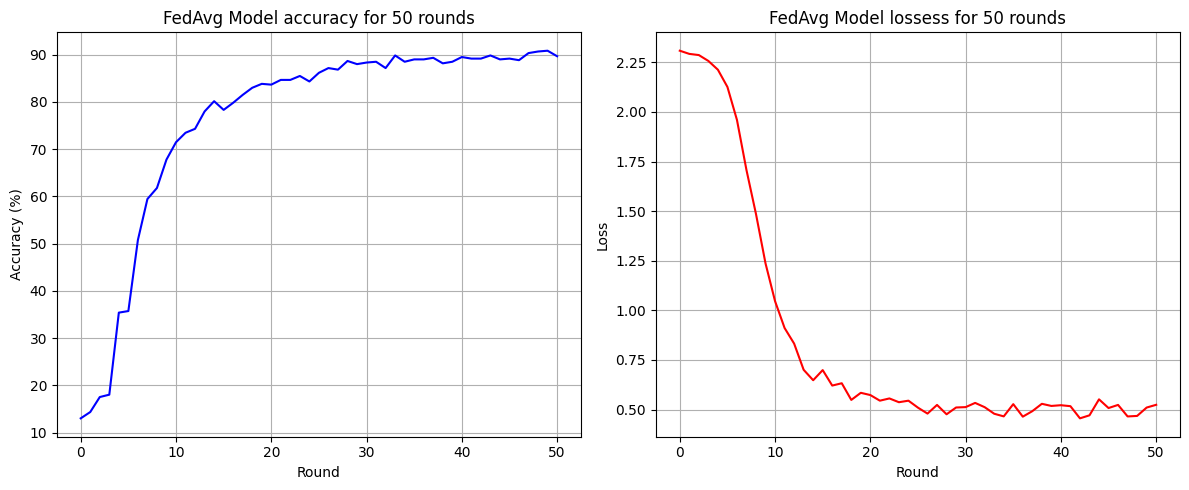

In [ ]:
import matplotlib.pyplot as plt

print("Average Accuracy Variance: ", np.mean(np.array(accuray_var_list)))
print("Average Loss Variance: ", np.mean(np.array(loss_var_list)))
print()
# Extract accuracy and loss data
global_accuracy_centralised = history.metrics_centralized["accuracy"]
global_loss_centralised = history.metrics_centralized["loss"]

# Plot accuracy
plt.figure(figsize=(12, 5))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)
round_acc = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round_acc, acc, color='b')
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("FedAvg Model accuracy for 50 rounds")
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
round_loss = [data[0] for data in global_loss_centralised]
loss = [data[1] for data in global_loss_centralised]
plt.plot(round_loss, loss, color='r')
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("FedAvg Model lossess for 50 rounds")
plt.grid()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()
